## Funções 

* As funções abaixo nos ajudarão na implementação e melhor entendimento da modelagem e pré-processamento, cada função possui a descrição da sua rotina de funcionamento.

In [1]:
import pandas as pd
from sklearn.metrics import r2_score
from timeseriesmetrics import theil

def computeAccuracyModels(model_name, city_name, y_pred, y_true):
    """
    Calcula as métricas Theil e R² para um modelo e localidade.
    Adiciona uma nova linha ao DataFrame consolidado com as colunas Localidade, Theil, R2 e Modelo.
    """
    global df_metrics  # DataFrame consolidado de métricas

    # Garantir que y_pred e y_true são arrays numpy ou pandas
    y_pred = y_pred.values if isinstance(y_pred, pd.Series) else y_pred
    y_true = y_true.values if isinstance(y_true, pd.Series) else y_true

    # Cálculo das métricas
    r2 = r2_score(y_true, y_pred)
    theil_stat = theil(y_true, y_pred)

    # Criar uma nova linha com as informações calculadas
    new_row = {
        'Localidade': city_name,
        'Theil': theil_stat,
        'R2': r2,
        'Modelo': model_name
    }

    # Adicionar a nova linha ao DataFrame
    df_metrics = pd.concat([df_metrics, pd.DataFrame([new_row])], ignore_index=True)

    
    
import matplotlib.pyplot as plt

# Função para aplicar Random Walk em múltiplas séries temporais

def random_walk_forecast_multiple(series_dict):
    forecast_results = {}
    
    for city_name, series in series_dict.items():

        # Previsão usando Random Walk
        y_forecast = series.shift(1)
        y_forecast.iloc[0] = series.iloc[0]  # Ajuste o primeiro valor para evitar NaN
        
        # Armazenar as previsões separadas para cada cidade
        forecast_results[city_name] = y_forecast
    
    return forecast_results


# Função para calcular os lags significantes

from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
   
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags


# Processa os resíduos de previsão e identifica os lags mais relevantes.    

def process_residuals_print(y_true, y_forecast, city_name, nLags=5, alpha=0.07):
    """
    # Processa os resíduos de previsão e identifica os lags mais relevantes.
    
    Parâmetros:
    - y_true: Série original.
    - y_forecast: Previsões da série.
    - city_name: Nome da cidade.
    - nLags: Número máximo de lags a serem analisados (padrão: 5).
    - alpha: Nível de significância para cálculo do PACF (padrão: 0.05).
    
    Retorno:
    - city_name: Nome da cidade.
    - significantLags: Lista com os lags significativos.
    """
    # Calcular resíduos (erro entre a série original e a previsão)
    residuos_serie = pd.DataFrame({
        'residuos': y_true - y_forecast
    }, index=y_true.index)
    
    # Identificar lags mais relevantes
    significantLags = getSignificantLags(residuos_serie['residuos'], nLags=nLags, alpha=alpha)
    
    return city_name, significantLags    


# Função para calcular resíduos, variáveis lagged e escalonamento para cada cidade

def process_residuals(y_true, y_forecast):
    # Calcular resíduos (erro entre a série original e a previsão)
    residuos_serie = y_true - y_forecast
    # Construir variáveis lagged para previsão
    X_residual = residuos_serie.shift(1)  # Resíduo defasado em um ponto
    # Ajustar os valores iniciais ausentes para consistência
    X_residual.iloc[0] = X_residual.iloc[1]  # Ajustar o primeiro valor

    X_residual.columns = ['Lag_1']


    y_residual = residuos_serie.loc[X_residual.index]  # Valores dos resíduos

    return X_residual, y_residual



# Função para aplicar a busca Bayesiana e salvar os melhores parâmetros


from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit
from ridge_sgd_kernelcopy import RidgeSGDKernelTorch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class RidgeSGDKernelTorchWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, eta=0.01, c=0.01, sigma=1.0):
        self.eta = eta
        self.c = c
        self.sigma = sigma
        self.model = None

    def fit(self, X, y):
        # Inicializar o modelo
        self.model = RidgeSGDKernelTorch(eta=self.eta, c=self.c, sigma=self.sigma)
        # Treinar online
        for x_new, y_new in zip(X, y):
            self.model.partial_fit(x_new, y_new)
        return self

    def predict(self, X):
        # Realizar previsões
        return np.array([self.model.predict(x) for x in X])


def apply_bayes_search_for_city(city, X, y, param_grid):
    # Criar o modelo de busca Bayesiana
    bayes_search = BayesSearchCV(
        RidgeSGDKernelTorchWrapper(),
        search_spaces=param_grid,
        n_iter=30,
        cv=TimeSeriesSplit(n_splits=3),
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Realizar a busca
    bayes_search.fit(X.values, y.values)

    # Obter os melhores parâmetros da busca
    best_params = bayes_search.best_params_

    # Criar e treinar o modelo com os melhores parâmetros encontrados
    ridge_sgd_torch_best = RidgeSGDKernelTorch(
        eta=best_params['eta'],
        c=best_params['c'],
        sigma=best_params['sigma']
    )

    # Lista para armazenar previsões
    y_pred_best = []

    # Treinar e prever de forma online com os dados
    for x_new, y_new in zip(X.values, y.values):
        prediction = ridge_sgd_torch_best.partial_fit(x_new, y_new)
        y_pred_best.append(prediction)

    # Previsões indexadas
    y_pred_bayes_indexed = pd.Series(y_pred_best, index=y.index)

    return y_pred_bayes_indexed, best_params


import matplotlib.pyplot as plt
import pandas as pd
from norm import RidgeSGDKernelTorchDict
import torch

def apply_model_and_plot(X_residual, y_residual, best_params):
    # Converter os dados em dicionários para serem compatíveis com o modelo
    X_residual_dict = {idx: x for idx, x in zip(y_residual.index, X_residual.values)}
    y_residual_dict = {idx: y for idx, y in zip(y_residual.index, y_residual.values)}

    # Instanciar o modelo com os melhores parâmetros encontrados para a cidade
    ridge_sgd_torch = RidgeSGDKernelTorchDict(eta=best_params['eta'], c=best_params['c'], sigma=best_params['sigma'])

    # Dicionário para armazenar previsões
    y_pred = {}

    # Treinar e prever de forma online com os dados residuais
    for idx in X_residual_dict.keys():
        x_new = X_residual_dict[idx]
        y_new = y_residual_dict[idx]

        # Atualizar o modelo com o novo ponto e obter a previsão diretamente
        pred_n = ridge_sgd_torch.partial_fit(x_new, y_new, idx)

        # Garantir que `pred_n` seja convertido corretamente para escalar
        if isinstance(pred_n, torch.Tensor):
            y_pred[idx] = pred_n.item()
        else:
            y_pred[idx] = pred_n

    # Converter as previsões em um pandas.Series para facilitar o plot
    y_pred_series = pd.Series(y_pred).sort_index()
    y_residual_series = pd.Series(y_residual_dict).sort_index()

    return y_residual_series, y_pred_series




# 1. Contextualização

Nos últimos anos, a oscilação nos preços da gasolina tornou-se um dos problemas mais debatidos no Brasil, especialmente devido à volatilidade acentuada a partir de 2020. Em março daquele ano, o litro de gasolina custava, em média, **R$ 4,598**, e no intervalo de 12 meses apresentou uma alta de **27,26%**. Entre 2020 e 2022, o preço da gasolina aumentou cerca de **2,6 vezes mais que a inflação acumulada**, medida pelo IPCA, que foi de **21,86%** no período, segundo o IBGE. Desde então, os preços têm variado semanalmente, alcançando **R$ 7,99** em alguns postos no ano de 2024, conforme dados da ANP.

Para esta análise, foram considerados os anos de **2019 a 2023**, um período marcado por intensas flutuações nos preços dos combustíveis. Essas oscilações foram influenciadas por uma combinação de fatores, incluindo as consequências econômicas da **pandemia de COVID-19**, que afetaram a produção e o consumo global; variações na cotação do **dólar**, dado que o Brasil depende de importações para parte de seu consumo de combustíveis; mudanças nas políticas de precificação da **Petrobras**, que ajusta os preços de acordo com o mercado internacional; além de flutuações no preço do **petróleo** no mercado global e eventos geopolíticos que impactaram o suprimento e a demanda por combustíveis.

Essa acentuada variação nos preços tornou a previsão de valores um desafio significativo. Esse tema tem despertado grande interesse tanto na **academia** quanto no **setor privado**, que buscam soluções para compreender e prever as mudanças no mercado de combustíveis. Apesar dos avanços recentes nos métodos de previsão, muitos modelos ainda enfrentam dificuldades para capturar com precisão tanto a **volatilidade** dos preços semanais quanto as **tendências de longo prazo**, o que reforça a necessidade de pesquisas contínuas e o desenvolvimento de ferramentas mais robustas para análise desse mercado.

Nosso objetivo será prever os resíduos do modelo **Randon Walk** de forma a ganhar dele nas metricas de erro e obter um melhor desempenho.
usaremos os modelos de NORMA(Naive Online regularized Risk Minimization Algorithm) com abordagem de dicionário e com abordagem de arrays numpy, também usaremos modelos ARIMA da biblioteca pmdarima e da river biblioteca.



# 2. Pré-Processamento



* O pré-processamento de dados é um conjunto de atividades que envolvem preparação, organização e estruturação dos dados.
Trata-se de uma etapa fundamental que precede a realização de análises e aplicação de modelos preditivos.Essa etapa é de grande importância, pois será determinante para a qualidade final dos dados que serão analisados.  

* Iniciamos o pré-processamento dos dados convertendo a coluna `Data da Coleta` para o formato `datetime` da  biblioteca pandas, este processo garante que estaremos trabalhando com datas e é de grande importãncia na modelagem dos dados.   
Em seguida usamos a coluna `Data da Coleta` como index.  
Este processo é feito para cada dataframe que será trabalhado.

* Abaixo lemos os dataframes para cada série que será trabalhada ao longo do notebook, conforme discutido anteriormente trabalharemos com as séries das capitais nordestinas.  

In [2]:
dados_salvador = pd.read_csv("data/Salvador_week.csv")
dados_fortaleza = pd.read_csv("data/Fortaleza_week.csv")
dados_teresina = pd.read_csv("data/Teresina_week.csv")
dados_saoluis = pd.read_csv("data/SaoLuis_week.csv")
dados_joaopessoa = pd.read_csv("data/JoaoPessoa_week.csv")
dados_natal = pd.read_csv("data/Natal_week.csv")

In [3]:
#salvador
dados_salvador['Data da Coleta'] = pd.to_datetime(dados_salvador['Data da Coleta'])
dados_salvador = dados_salvador.set_index('Data da Coleta')
#fortaleza
dados_fortaleza['Data da Coleta'] = pd.to_datetime(dados_fortaleza['Data da Coleta'])
dados_fortaleza = dados_fortaleza.set_index('Data da Coleta')
# teresina
dados_teresina['Data da Coleta'] = pd.to_datetime(dados_teresina['Data da Coleta'])
dados_teresina = dados_teresina.set_index('Data da Coleta')
#sao luis
dados_saoluis['Data da Coleta'] = pd.to_datetime(dados_saoluis['Data da Coleta'])
dados_saoluis = dados_saoluis.set_index('Data da Coleta')
#joao pessoa
dados_joaopessoa['Data da Coleta'] = pd.to_datetime(dados_joaopessoa['Data da Coleta'])
dados_joaopessoa = dados_joaopessoa.set_index('Data da Coleta')
# Natal
dados_natal['Data da Coleta'] = pd.to_datetime(dados_natal['Data da Coleta'])
dados_natal = dados_natal.set_index('Data da Coleta')

## 2.1 Análise descritiva

Ao analisar as séries temporais dos preços da gasolina, podemos observá-los em quatro momentos principais:

**Período anterior a 2020**: Antes de 2020, os preços da gasolina apresentavam uma variação moderada. Embora houvesse uma leve subida seguida de uma queda, os preços raramente ultrapassavam a marca de 5 reais. Na maior parte das cidades, o preço se manteve dentro de um intervalo relativamente estável, sem grandes flutuações. A exceção notável foi Salvador, onde o preço da gasolina permaneceu praticamente constante durante esse período, sem grandes variações, o que pode estar relacionado à dinâmica local do mercado de combustíveis e políticas regionais.

**Início da pandemia de COVID-19 (2020)**: Com o advento da pandemia de COVID-19 no início de 2020, o cenário econômico mundial sofreu uma forte mudança. Nos primeiros meses do ano, os preços da gasolina caíram, reflexo da queda na demanda global de combustíveis devido ao isolamento social e à paralisação de diversas atividades econômicas. No entanto, logo após essa queda inicial, o preço começou a aumentar de forma significativa. Esse aumento foi impulsionado pela crise econômica global provocada pela pandemia, que afetou o mercado de petróleo e combustíveis, além de desajustes nas cadeias de fornecimento. O impacto da pandemia causou uma elevação generalizada dos preços da gasolina em diversas partes do mundo, incluindo o Brasil, onde o mercado local foi afetado pela instabilidade econômica.

**Após 2022** – Queda e recuperação (2022): Em 2022, a situação econômica no Brasil e no mundo começou a se estabilizar parcialmente. Os preços da gasolina passaram a se manter mais constantes por algumas semanas, mas logo em seguida iniciaram uma nova tendência de crescimento. Essa variação foi diretamente influenciada por fatores como a recuperação econômica global pós-pandemia, o aumento da demanda por combustíveis à medida que a economia voltava ao normal e as flutuações nos preços do petróleo no mercado internacional. No entanto, o grande evento que afetou fortemente os preços foi a eleição presidencial no Brasil no final de 2022. Durante esse período, a política interna teve um papel importante na regulação dos preços dos combustíveis. O governo que estava saindo adotou políticas de redução de impostos sobre combustíveis para tentar aliviar o impacto da alta dos preços, o que resultou em uma queda significativa nos preços no final de 2022. Essa mudança foi vista como uma tentativa de controlar a inflação e conquistar apoio popular em um momento de grande tensão política e social.

**Início de 2023** – Mudanças políticas e novo padrão de preços (2023): O início de 2023 foi marcado pela posse de um novo presidente no Brasil, o que trouxe novas diretrizes econômicas e políticas para o país. Nesse período, os preços da gasolina voltaram a subir, impulsionados principalmente por ajustes nas políticas de preços dos combustíveis e pela adaptação do mercado a um novo cenário econômico. O novo governo adotou uma série de medidas que afetaram diretamente o mercado de combustíveis, incluindo a revisão da política de subsídios e o controle da inflação. Apesar disso, os preços se estabilizaram em torno de 5 a 6 reais em muitas cidades, embora algumas localidades, como Fortaleza e Natal, registrassem valores mais altos devido a fatores regionais e à oferta local de combustíveis. A política fiscal e a postura do novo governo em relação ao setor energético continuaram a influenciar a dinâmica de preços durante esse período, com tentativas de equilibrar o custo para o consumidor e a sustentabilidade das finanças públicas.  


**Conclusão**:
O preço da gasolina no Brasil, assim como em outros países, é influenciado por uma complexa interação de fatores econômicos, políticos e sociais. A análise das séries temporais revela que, ao longo dos últimos anos, essas variáveis exerceram um impacto significativo nas flutuações de preços.

Primeiramente, fatores econômicos globais, como a pandemia de COVID-19, desempenharam um papel crucial, provocando quedas iniciais seguidas de aumentos expressivos nos preços da gasolina. A crise sanitária gerou uma desestabilização das cadeias de fornecimento, elevando os custos dos combustíveis, enquanto a recuperação econômica trouxe uma nova pressão sobre os preços. No Brasil, a política interna também teve grande peso, especialmente em momentos de incerteza política, como nas eleições de 2022, quando mudanças nas políticas fiscais, como a redução de impostos sobre combustíveis, resultaram em uma queda temporária no preço.

Além disso, o impacto de decisões políticas no setor energético, especialmente com a troca de governos, revelou-se fundamental para moldar o comportamento dos preços nos anos seguintes. O novo governo de 2023, ao adotar medidas voltadas ao controle da inflação e à gestão da política de preços dos combustíveis, teve uma influência direta no aumento gradual dos preços, com algumas regiões, como Fortaleza e Natal, mostrando variações ainda mais pronunciadas.

Portanto, o preço da gasolina é resultado de uma confluência de fatores globais, nacionais e regionais, com o mercado de combustíveis sendo sensível a mudanças econômicas externas, como o valor do petróleo, e a decisões políticas internas, que buscam equilibrar interesses econômicos e sociais. A compreensão desses múltiplos impactos é essencial para analisar o comportamento dos preços e suas variações ao longo do tempo, evidenciando a complexidade desse mercado e a necessidade de políticas públicas que considerem tanto os desafios econômicos globais quanto as realidades locais.

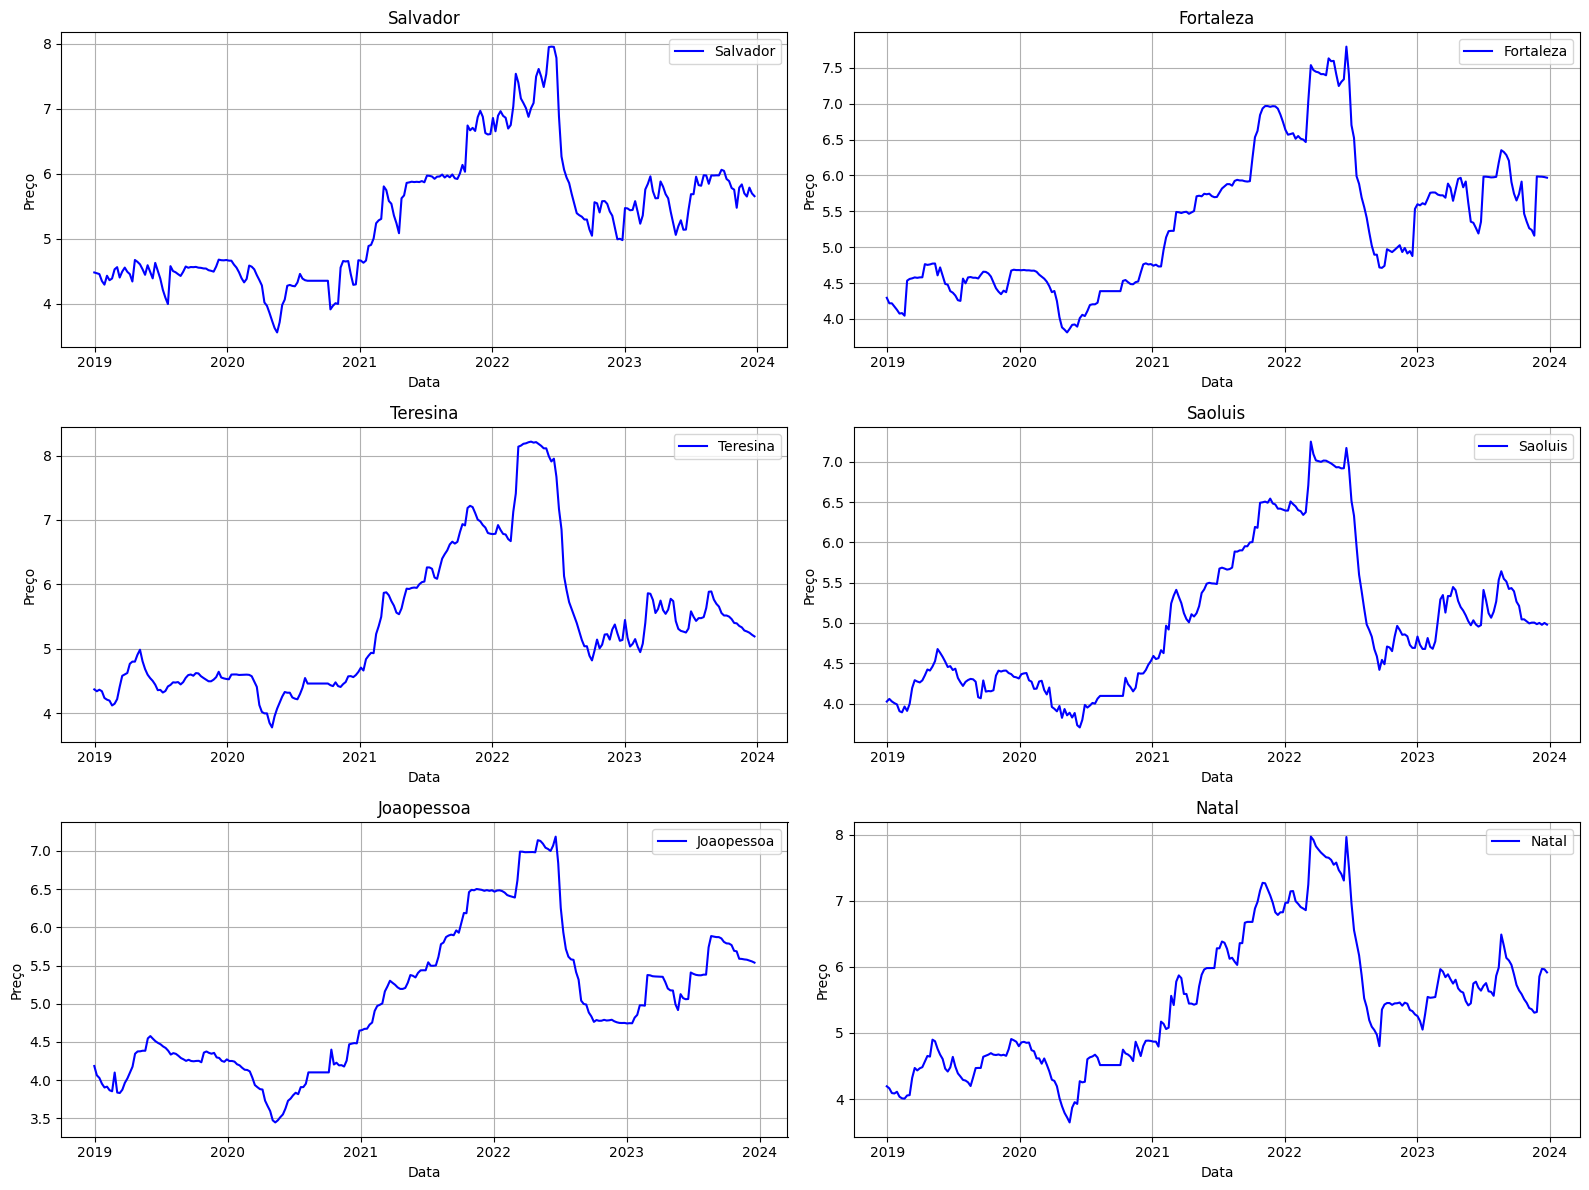

In [4]:
# Dicionário com as séries temporais de cada cidade
series_dict = {
    'salvador': dados_salvador['Valor de Venda'],
    'fortaleza': dados_fortaleza['Valor de Venda'],
    'teresina': dados_teresina['Valor de Venda'],
    'saoluis': dados_saoluis['Valor de Venda'],
    'joaopessoa': dados_joaopessoa['Valor de Venda'],
    'natal': dados_natal['Valor de Venda']
}

cities = list(series_dict.keys())
n_cities = len(cities)

# Definir número de colunas e linhas para os subgráficos (grade)
n_cols = 2  #
n_rows = (n_cities + 1) // n_cols  # Número de linhas baseado no número de cidades

# Criar subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Ajustar o layout para garantir que os subgráficos não se sobreponham
plt.tight_layout()

for i, city_name in enumerate(cities):
    row = i // n_cols  # Determinar a linha do subplot
    col = i % n_cols  # Determinar a coluna do subplot
    
    ax = axes[row, col] if n_rows > 1 else axes[col]  # Selecionar o eixo correto
    
    # Plotar valores reais e previstos para a cidade
    ax.plot(series_dict[city_name], label=f'{city_name.capitalize()}', color='blue')

    # Títulos e legendas
    ax.set_title(f'{city_name.capitalize()}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço')
    ax.legend()
    ax.grid(True)
    
plt.tight_layout()
plt.show() 
   

* No codigo abaixo escolhemos a coluna target, ou seja, a coluna alvo do nosso dataframe, esta coluna é o dado que queremos prever.  
É crucial fazer um bom tratamento nesta coluna para que não haja vazamento de dados nos  modelos, pois isto comprometeria toda modelagem.  
Tratamos a coluna target como um objeto dicionário, isto é necessario em processos específicos de modelagem que veremos a seguir.

In [5]:
from sklearn.pipeline import Pipeline
import pandas as pd

# Lista das séries temporais em um dicionário
dados_series = {
    "salvador": dados_salvador,
    "fortaleza": dados_fortaleza,
    "teresina": dados_teresina,
    "saoluis": dados_saoluis,
    "joaopessoa": dados_joaopessoa,
    "natal": dados_natal
}



# Dicionário para armazenar os resultados transformados
series_transformadas = {}

# Iterando sobre as séries temporais
for nome, dados in dados_series.items():

    y = dados['Valor de Venda']

    series_transformadas[nome] = {
        "y": y
    }


y_fortaleza = series_transformadas["fortaleza"]["y"]
y_salvador = series_transformadas["salvador"]["y"]
y_joaopessoa = series_transformadas["joaopessoa"]["y"]
y_saoluis = series_transformadas["saoluis"]["y"]
y_teresina = series_transformadas["teresina"]["y"]
y_natal = series_transformadas["natal"]["y"]



* A seguir partimos para uma etapa que pode ser considerada como modelagem e como pré-processamento.O processo que se segue define um modelo randonWalk para cada série, o modelo randonWalk é conhecido por sua simplicidade e por seu poder preditivo, este modelo costuma ganhar de muitos modelos robustos aplicados a séries temporais.   
Conforme citado nosso objetivo será prever os resíduos do modelo **Randon Walk** de forma a ganhar dele nas metricas de erro e obter um melhor desempenho.

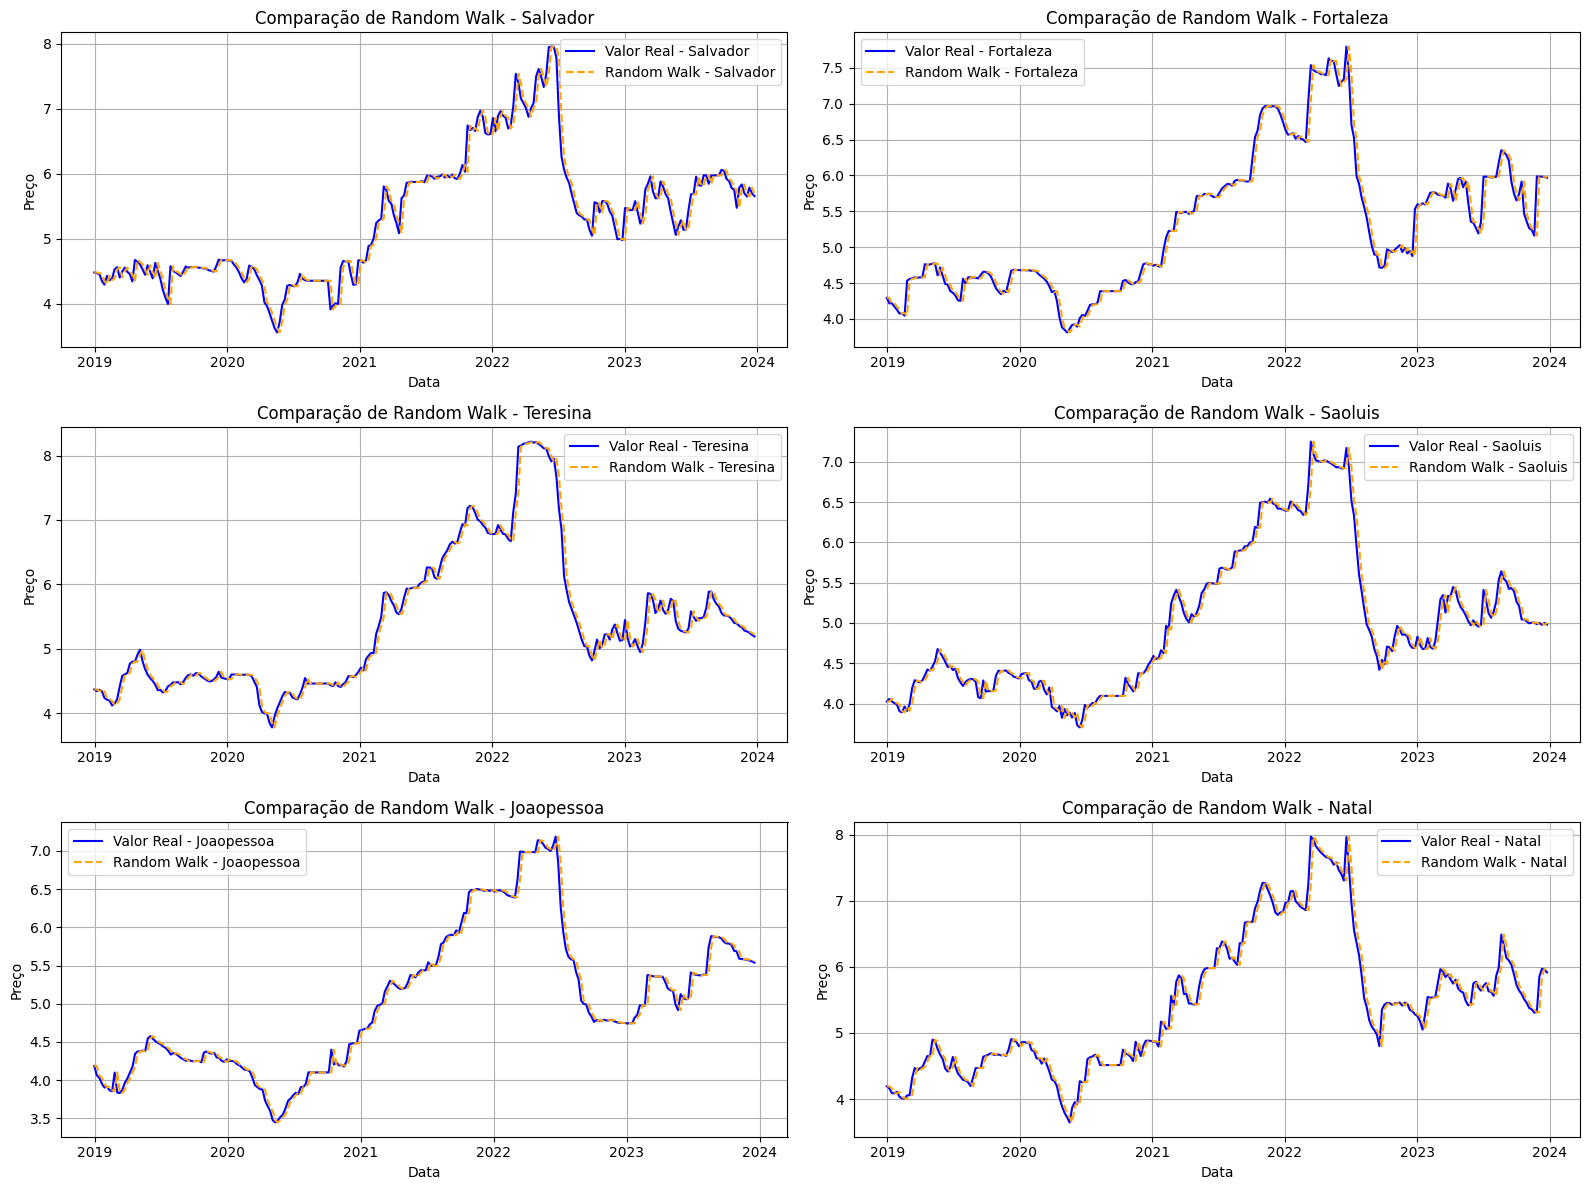

In [6]:


# Dicionário com as séries temporais de cada cidade
series_dict = {
    'salvador': dados_salvador['Valor de Venda'],
    'fortaleza': dados_fortaleza['Valor de Venda'],
    'teresina': dados_teresina['Valor de Venda'],
    'saoluis': dados_saoluis['Valor de Venda'],
    'joaopessoa': dados_joaopessoa['Valor de Venda'],
    'natal': dados_natal['Valor de Venda']
}

# Aplicar Random Walk em todas as séries
forecasts = random_walk_forecast_multiple(series_dict)

# Agora podemos acessar as previsões para cada cidade separadamente
y_forecast_salvador = forecasts['salvador']
y_forecast_fortaleza = forecasts['fortaleza']
y_forecast_teresina = forecasts['teresina']
y_forecast_saoluis = forecasts['saoluis']
y_forecast_joaopessoa = forecasts['joaopessoa']
y_forecast_natal = forecasts['natal']

# Número de cidades (para calcular a grade de subplots)
cities = list(series_dict.keys())
n_cities = len(cities)

# Definir número de colunas e linhas para os subgráficos (grade)
n_cols = 2  #
n_rows = (n_cities + 1) // n_cols  # Número de linhas baseado no número de cidades

# Criar subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Ajustar o layout para garantir que os subgráficos não se sobreponham
plt.tight_layout()

# Plotar as previsões para todas as séries
for i, city_name in enumerate(cities):
    row = i // n_cols  # Determinar a linha do subplot
    col = i % n_cols  # Determinar a coluna do subplot
    
    ax = axes[row, col] if n_rows > 1 else axes[col]  # Selecionar o eixo correto
    
    # Plotar valores reais e previstos para a cidade
    ax.plot(series_dict[city_name], label=f'Valor Real - {city_name.capitalize()}', color='blue')
    ax.plot(forecasts[city_name], label=f'Random Walk - {city_name.capitalize()}', linestyle='--', color='orange')
    
    # Títulos e legendas
    ax.set_title(f'Comparação de Random Walk - {city_name.capitalize()}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço')
    ax.legend()
    ax.grid(True)

# Exibir os gráficos
plt.tight_layout()

plt.show()




**Metricas para o modelo Randon Walk** 

* É possivel ver que as medidas de erro ficaram bem semelhantes para cada série.  
Os valores de **R²** são todos altos (próximos de 1), indicando que o Random Walk está capturando bem a variabilidade dos dados.
Os valores de theil obserados mostram que todas as localidades apresentam Theil = 1, indicando que o Random Walk está no mesmo nível de desempenho que o modelo de persistência. Em outras palavras, não há ganho em termos de previsão ao utilizar o modelo de Random Walk comparado a simplesmente usar o último valor observado como previsão.   
Portanto, é possivel ver que embora o R² mostre que o Random Walk é eficaz em explicar a variância dos dados, o índice de Theil indica que ele não oferece uma vantagem sobre a previsão de persistência. Isso sugere que, para esses dados, o padrão de Random Walk pode ser suficiente para representar as séries temporais. Se o objetivo é melhorar as previsões, talvez seja necessário introduzir um modelo mais complexo ou incorporar mais variáveis explicativas.

* A seguir plotamos as metricas obtidas pelo modelo **randonWalk**. 


In [7]:
# DataFrame inicial com localidades
df_metrics = pd.DataFrame({'Localidade': ['Teresina', 'Salvador', 'São Luís', 'João Pessoa', 'Fortaleza', 'Natal']})


computeAccuracyModels('Random Walk', 'Teresina', y_forecast_teresina, y_teresina)
computeAccuracyModels('Random Walk', 'Salvador', y_forecast_salvador, y_salvador)
computeAccuracyModels('Random Walk', 'São Luís', y_forecast_saoluis, y_saoluis)
computeAccuracyModels('Random Walk', 'João Pessoa', y_forecast_joaopessoa, y_joaopessoa)
computeAccuracyModels('Random Walk', 'Fortaleza', y_forecast_fortaleza, y_fortaleza)
computeAccuracyModels('Random Walk', 'Natal', y_forecast_natal, y_natal)

df_metrics = df_metrics.iloc[6:]

# Exibindo o DataFrame consolidado
display(df_metrics)



,Localidade,Theil,R2,Modelo
6,Teresina,1.0,0.985459,Random Walk
7,Salvador,1.0,0.968224,Random Walk
8,São Luís,1.0,0.983725,Random Walk
9,João Pessoa,1.0,0.989240,Random Walk
10,Fortaleza,1.0,0.975590,Random Walk
11,Natal,1.0,0.977150,Random Walk


- Nosso objetivo é prever os resíduos do modelo **Random Walk**, utilizando variáveis preditoras baseadas nos lags desses resíduos. Os lags representam a influência dos valores passados de uma série temporal sobre os valores futuros, capturando padrões de autocorrelação importantes para modelagem preditiva.

- Ao analisar os resíduos, identificamos que o lag 1 é o mais relevante para todas as séries temporais. Isso significa que o valor imediatamente anterior exerce maior influência sobre a previsão do próximo valor. Selecionar apenas os lags mais relevantes, como o **lag 1**, melhora a eficiência do modelo ao reduzir ruídos e evitar a inclusão de variáveis irrelevantes, tornando as predições mais robustas e precisas.

In [8]:
# Lista de cidades e seus respectivos dados
cities = [
    ('Salvador', y_salvador, y_forecast_salvador),
    ('Fortaleza', y_fortaleza, y_forecast_fortaleza),
    ('Teresina', y_teresina, y_forecast_teresina),
    ('São Luís', y_saoluis, y_forecast_saoluis),
    ('João Pessoa', y_joaopessoa, y_forecast_joaopessoa),
    ('Natal', y_natal, y_forecast_natal)
]

# Processar e exibir lags relevantes para cada cidade
for city_name, y_true, y_forecast in cities:
    city, significantLags = process_residuals_print(y_true, y_forecast, city_name)
    print(f"City: {city}, Significant Lags: {significantLags}")


Lags Significantes: [1]
City: Salvador, Significant Lags: [1]
Lags Significantes: [1]
City: Fortaleza, Significant Lags: [1]
Lags Significantes: [1]
City: Teresina, Significant Lags: [1]
Lags Significantes: [1, 4]
City: São Luís, Significant Lags: [1, 4]
Lags Significantes: [1]
City: João Pessoa, Significant Lags: [1]
Lags Significantes: [1]
City: Natal, Significant Lags: [1]


* Em seguida usamo a função `process_residuals` para criar os nossos preditores(**lag 1**) e serão base para prever o valor dos residuos do **Randon Walk** para cada uma de nossas séries.   
Com essa etapa nos temos o preditor **lag 1** e o target **Residuos do Randon Walk** para cada uma de nossas series.

In [9]:
# Processar cada cidade individualmente
X_residual_salvador, y_residual_salvador = process_residuals(y_salvador, y_forecast_salvador)
X_residual_fortaleza, y_residual_fortaleza = process_residuals(y_fortaleza, y_forecast_fortaleza)
X_residual_teresina, y_residual_teresina = process_residuals(y_teresina, y_forecast_teresina)
X_residual_saoluis, y_residual_saoluis = process_residuals(y_saoluis, y_forecast_saoluis)
X_residual_joaopessoa, y_residual_joaopessoa = process_residuals(y_joaopessoa, y_forecast_joaopessoa)
X_residual_natal, y_residual_natal = process_residuals(y_natal, y_forecast_natal)

# 3. Modelagem

**Descida de Gradiente Estocástica com Kernels Conceitos Matematicos**

O problema inicial que se deseja resolver é o da **regressão ridge com kernels**. A função de custo a ser minimizada é:

$$
J = \|y - \phi(X)\phi(w)\|^2 + c\|\phi(w)\|^2
$$

- $y$ são os valores reais (observados).
- $\phi(X)$ é a transformação dos dados de entrada $X$ em um espaço de dimensão superior, realizada por uma função de kernel.
- $\phi(w)$ são os pesos do modelo.
- $c$ é o parâmetro de regularização que ajuda a evitar overfitting, penalizando valores grandes dos pesos $w$.

A regularização ridge faz com que o modelo não se ajuste excessivamente aos dados de treino, permitindo melhor generalização.

**Descida de Gradiente Estocástica (SGD) com Kernels**

A **descida de gradiente** é uma técnica de otimização iterativa, e na sua forma estocástica (SGD), o ajuste dos parâmetros do modelo é feito a cada nova observação de dado, o que reduz os custos computacionais comparados à descida de gradiente tradicional, que usaria todo o conjunto de dados a cada iteração.

O **passo de descida de gradiente** para ajustar os pesos $w$ do modelo é dado pela fórmula:

$$
\phi(w) \leftarrow \phi(w) - \eta \frac{1}{2} \frac{\partial J}{\partial \phi(w)}
$$

Aqui:
- $\eta$ é a **taxa de aprendizado** (um valor pequeno que controla o tamanho do passo).
- $\frac{\partial J}{\partial \phi(w)}$ é o gradiente da função de custo em relação aos pesos $w$, que nos indica a direção da maior inclinação da função de custo.

**Estimativa Instantânea do Gradiente**

Como estamos lidando com SGD, usamos uma **estimativa instantânea** do gradiente (baseada apenas no dado atual $x_n$ e sua resposta $y_n$) em vez de calcular o gradiente completo sobre todo o conjunto de dados.

Ao calcular a derivada parcial da função de custo, e ignorando momentaneamente a regularização $c$, a regra de atualização do peso $w$ fica assim:



$$
\phi(w_n) = \phi(w_{n-1}) + \eta \left( y_n \phi(x_n) - \phi(x_n) \phi(w_{n-1})^T \phi(x_n) \right)
$$

Este é o passo de ajuste para o peso $w$ no instante $n$. 

- A expressão $y_n \phi(x_n)$ está associada ao erro entre o valor predito pelo modelo e o valor verdadeiro.
- O termo $\phi(x_n) \phi(w_{n-1})^T \phi(x_n)$ representa a previsão feita pelo modelo com base no dado anterior.

Isso pode ser simplificado com o uso do erro instantâneo $e_n$:

$$
e_n = y_n - \phi(x_n)^T \phi(w_{n-1})
$$

Então, a regra de atualização torna-se:

$$
\phi(w_n) = \phi(w_{n-1}) + \eta e_n \phi(x_n)
$$

Ao confiar no Teorema do Representante, $\varphi(w_n)$ e $\varphi(w_{n-1})$ são expressos como combinações lineares dos dados transformados, resultando em:

$$
\sum_{i=1}^{n} \alpha_n(i) \varphi(x_i) = \sum_{i=1}^{n-1} \alpha_{n-1}(i) \varphi(x_i) + \eta e_n \varphi(x_n)
$$

onde $\alpha_n(i)$ denota o i-ésimo elemento do vetor $\alpha_n$. Se a regularização não for omitida, a regra de atualização fica:

$$
\sum_{i=1}^{n} \alpha_n(i) \varphi(x_i) = (1 - \eta c) \sum_{i=1}^{n-1} \alpha_{n-1}(i) \varphi(x_i) + \eta e_n \varphi(x_n).\tag{1}
$$

O Algoritmo de Minimização de Risco Regularizado Online (NORMA) é uma família de algoritmos estocásticos baseados em gradiente online e kernel . Ele inclui regularização e, portanto, utiliza a Eq. (1) como sua atualização básica. Vamos focar em sua forma padrão para regressão com uma função de perda quadrática. Concentrando toda a novidade nos novos coeficientes $\alpha_n$, a atualização para o NORMA no passo de tempo $n$ é dada por:

$$
\alpha_n = (1 - \eta c) \alpha_{n-1} + \eta e_n
, \tag{2}
$$

Note que os coeficientes diminuem à medida que $n$ cresce. Portanto, após um certo número de iterações, o coeficiente mais antigo pode ser descartado sem afetar a qualidade da solução. Assim, um mecanismo de dicionário de janela deslizante é obtido, o que impede que a representação funcional cresça de forma excessiva durante a operação online.

## 3.1 Modelo NORMA com Busca Bayesiana

* Conforme citado acima usaremos um modelo de gradiente descendente online baseado em kernels, especificamente o modelo **NORMA**(Naive Online regularized Risk Minimization Algorithm), usaremos este modelo com auxilio da busca bayesiana para encontra  os melhores parametros para a regressão ridge com gradiente descendente estocástico.
A seguir temos os a previsão para os residuos com o modelo **NORMA** com busca bayesiana e támbem os melhores parâmetros encontrados para a regressão ridge com gradiente descendente estocástico.

* **Interpretação dos parâmetros**:   
 * **Parâmetro $c$: Regularização**
        - **$c = 1.0$** para todas as localidades:  
        - Esse valor regula a complexidade do modelo. Um $c$ mais alto permite que o modelo se ajuste mais fortemente aos dados (risco de overfitting), enquanto um valor baixo prioriza a simplicidade (risco de underfitting).  
        - Como todas as localidades têm $c = 1.0$, o mesmo nível de regularização foi usado, indicando que o foco é equilibrar bias e variância de maneira uniforme.  

 * **Parâmetro $\eta$: Taxa de aprendizado**
        - **$\eta$ varia entre 0.1 e 0.7**:  
        - Salvador, Teresina, São Luís, João Pessoa e Natal têm $\eta = 0.1$, indicando uma taxa de aprendizado mais conservadora, com passos menores nas atualizações de gradiente.  
        - Fortaleza tem $\eta = 0.7$, indicando uma taxa de aprendizado maior, com passos mais agressivos.  
        - Essa diferença sugere que o modelo ajustado para Fortaleza foi configurado para convergir mais rapidamente, o que pode ser devido a uma maior variabilidade ou a características distintas nos dados dessa localidade.  

 * **3Parâmetro $\sigma$: Kernel (Gaussiano/RBF)**
        - **$\sigma = 0.3$** para todas as localidades:  
        - Esse valor controla a largura da função de kernel RBF, afetando o "alcance" da influência dos dados no espaço de alta dimensão.  
        - Com $\sigma = 0.3$, o kernel cria uma relação mais localizada entre os pontos, priorizando similaridades em curtas distâncias no espaço de entrada.  

Esta arquitetura é salva de modo a verificar se a abordagem com dicionários e parâmetros otimizados via buscam bayesiana obtem os mesmo resultados.

c:\Users\kaio\OneDrive\Área de Trabalho\Series Temporais\ridge_sgd_kernelcopy.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new_tensor = torch.tensor(x_new, dtype=torch.float32)
c:\Users\kaio\OneDrive\Área de Trabalho\Series Temporais\ridge_sgd_kernelcopy.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new_tensor = torch.tensor(x_new, dtype=torch.float32)
c:\Users\kaio\OneDrive\Área de Trabalho\Series Temporais\ridge_sgd_kernelcopy.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new_tensor = torch.tensor(x_new, dtyp

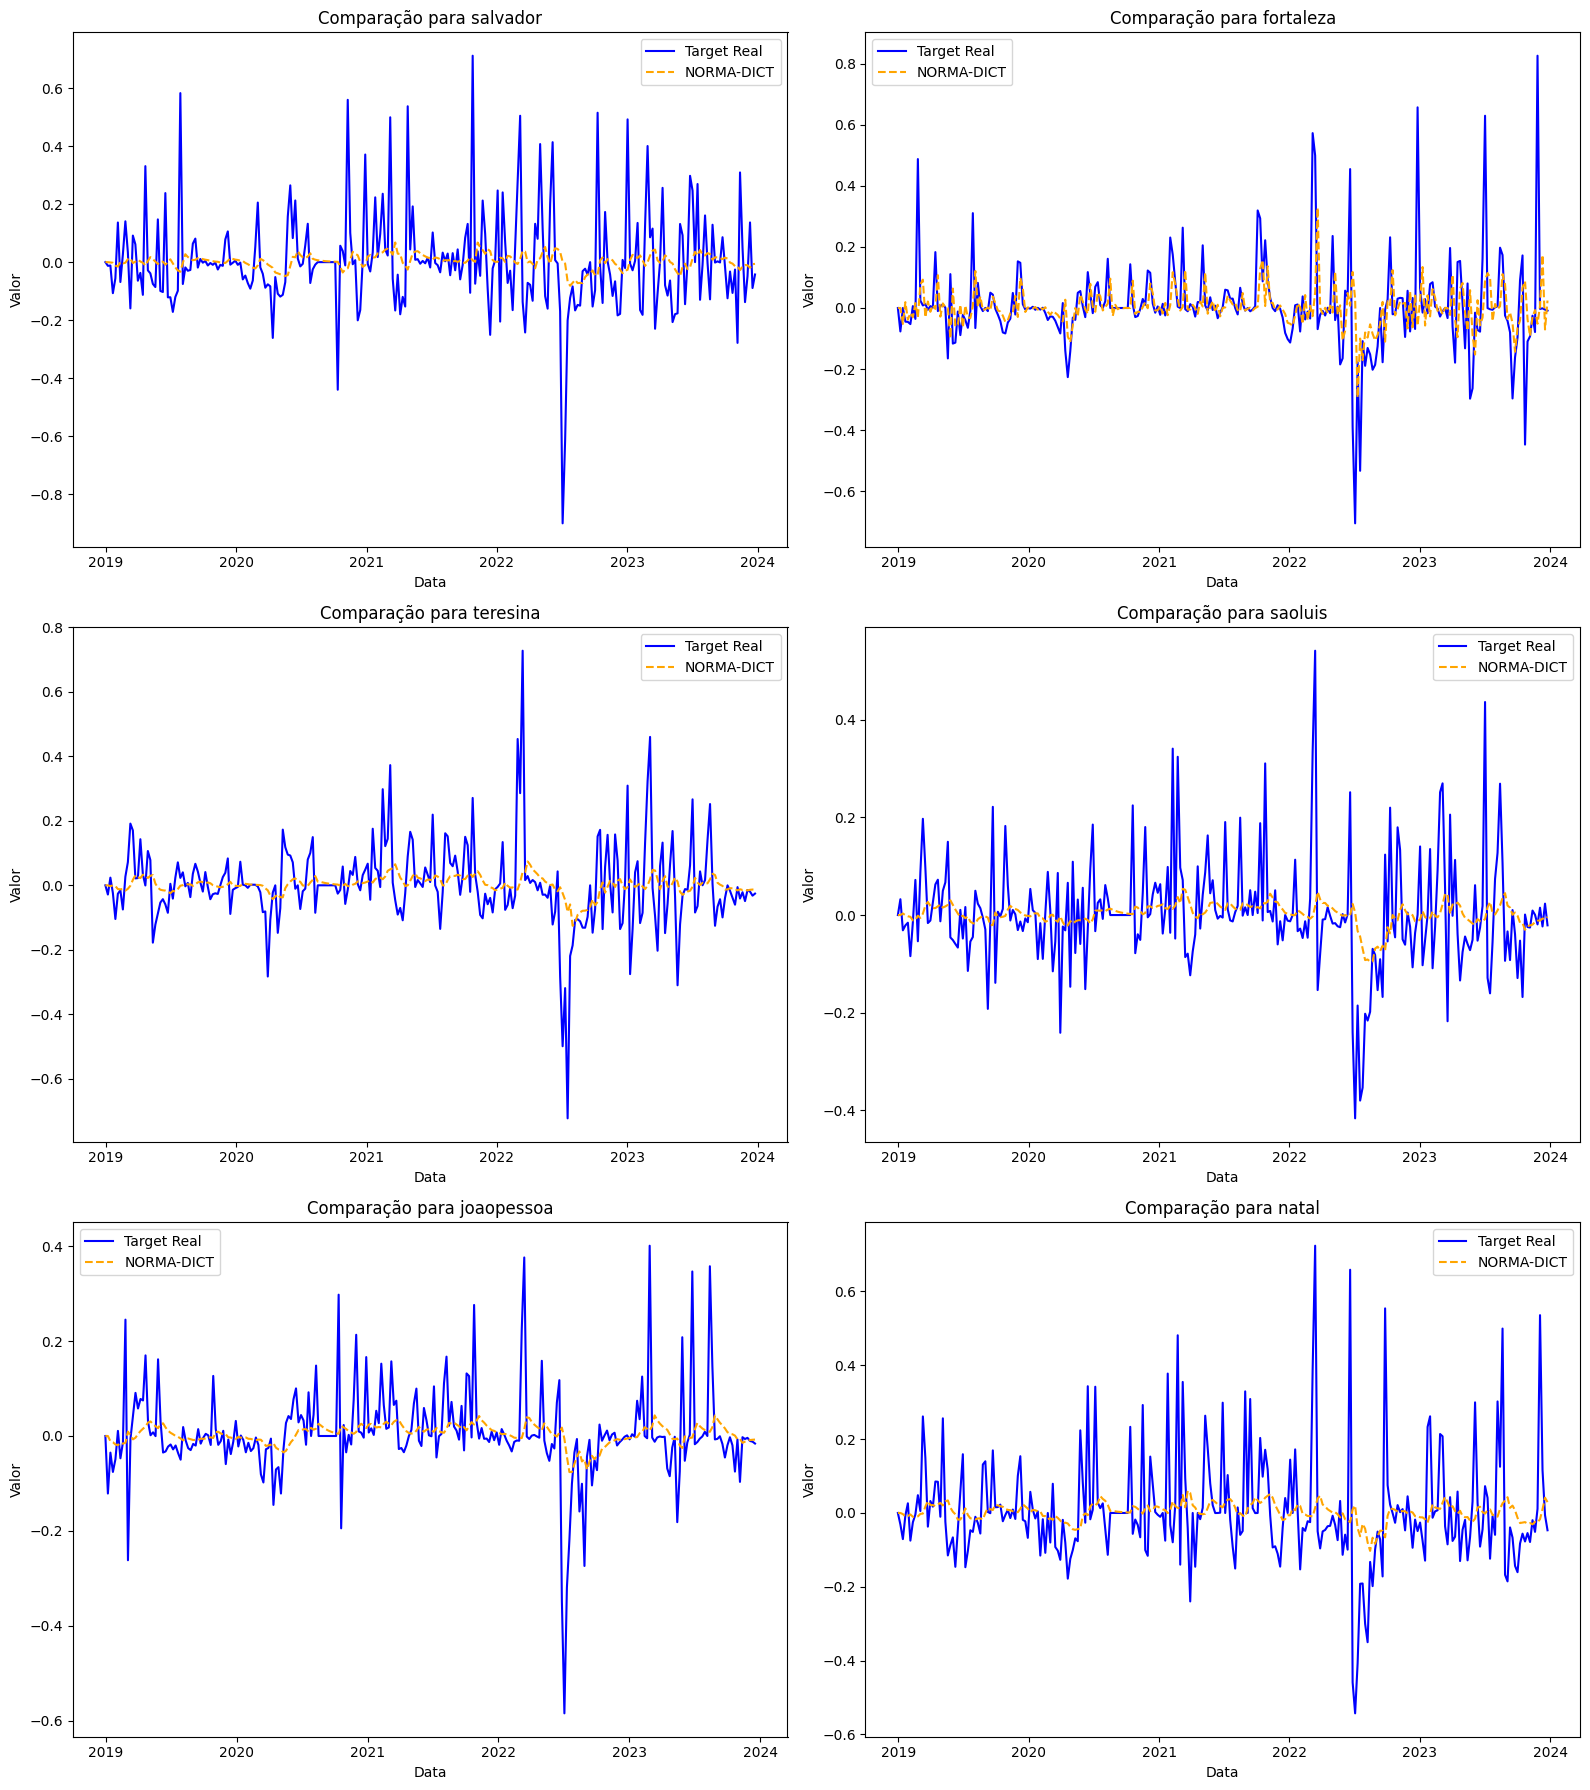

,c,eta,sigma
salvador,1.0,0.1,0.3
fortaleza,1.0,0.7,0.3
teresina,1.0,0.1,0.3
saoluis,1.0,0.1,0.3
joaopessoa,1.0,0.1,0.3
natal,1.0,0.1,0.3


In [10]:

# Definir o espaço de busca dos hiperparâmetros
param_grid = {
    'eta': (0.1, 0.7, 'log-uniform'),
    'c': (0.5, 1, 'log-uniform'),
    'sigma': (0.3, 1.5, 'uniform')
}


# Dicionário com os dados das cidades
cities = {
    'salvador': (X_residual_salvador, y_residual_salvador),
    'fortaleza': (X_residual_fortaleza, y_residual_fortaleza),
    'teresina': (X_residual_teresina, y_residual_teresina),
    'saoluis': (X_residual_saoluis, y_residual_saoluis),
    'joaopessoa': (X_residual_joaopessoa, y_residual_joaopessoa),
    'natal': (X_residual_natal, y_residual_natal)
}

# Dicionário para armazenar os melhores parâmetros e previsões
best_params_dict = {}
predictions = {}

# Criar a grade para os gráficos
n_cities = len(cities)
n_cols = 2
n_rows = (n_cities + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
axes = axes.flatten()

# Aplicar a busca Bayesiana e gerar gráficos
for i, (city, (X, y)) in enumerate(cities.items()):
    # Obter previsões e melhores parâmetros
    y_pred, best_params = apply_bayes_search_for_city(city, X, y, param_grid)

    # Salvar no dicionário
    best_params_dict[city] = best_params
    predictions[city] = y_pred

    # Plotar os dados
    ax = axes[i]
    ax.plot(y, label='Target Real', color='blue')  
    ax.plot(y_pred, label=f'NORMA-DICT', linestyle='--', color='orange') 
    ax.set_title(f'Comparação para {city}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor')
    ax.legend()

# Remover os eixos não utilizados
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajustar o layout e exibir os gráficos
plt.tight_layout()
plt.show()

# Salvar os melhores parâmetros em um DataFrame para visualização ou exportação
best_params_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
display(best_params_df)




# AO inves da palavea previsto usar  o nome do modelo

* No código abaixo os valores previstos são salvos para serem usados no boosting.

In [11]:
y_predic_salvador = predictions['salvador']
y_predic_natal = predictions['natal']
y_predic_fortaleza = predictions['fortaleza']
y_predic_teresina = predictions['teresina']
y_predic_saoluis = predictions['saoluis']
y_predic_joaopessoa = predictions['joaopessoa']
        

* Abaixo é feito o boosting no modelo **Randon Walk** ou seja somamos a previsão do modelo **Randon Walk** com os valores previstos para o residuo buscando assim melhorar a previsão dos  valores de venda de gasolina para cada cidade.   
Em seguida é feito a plotagem dos gráficos onde mostram o  boosting e o valor real para cada série.

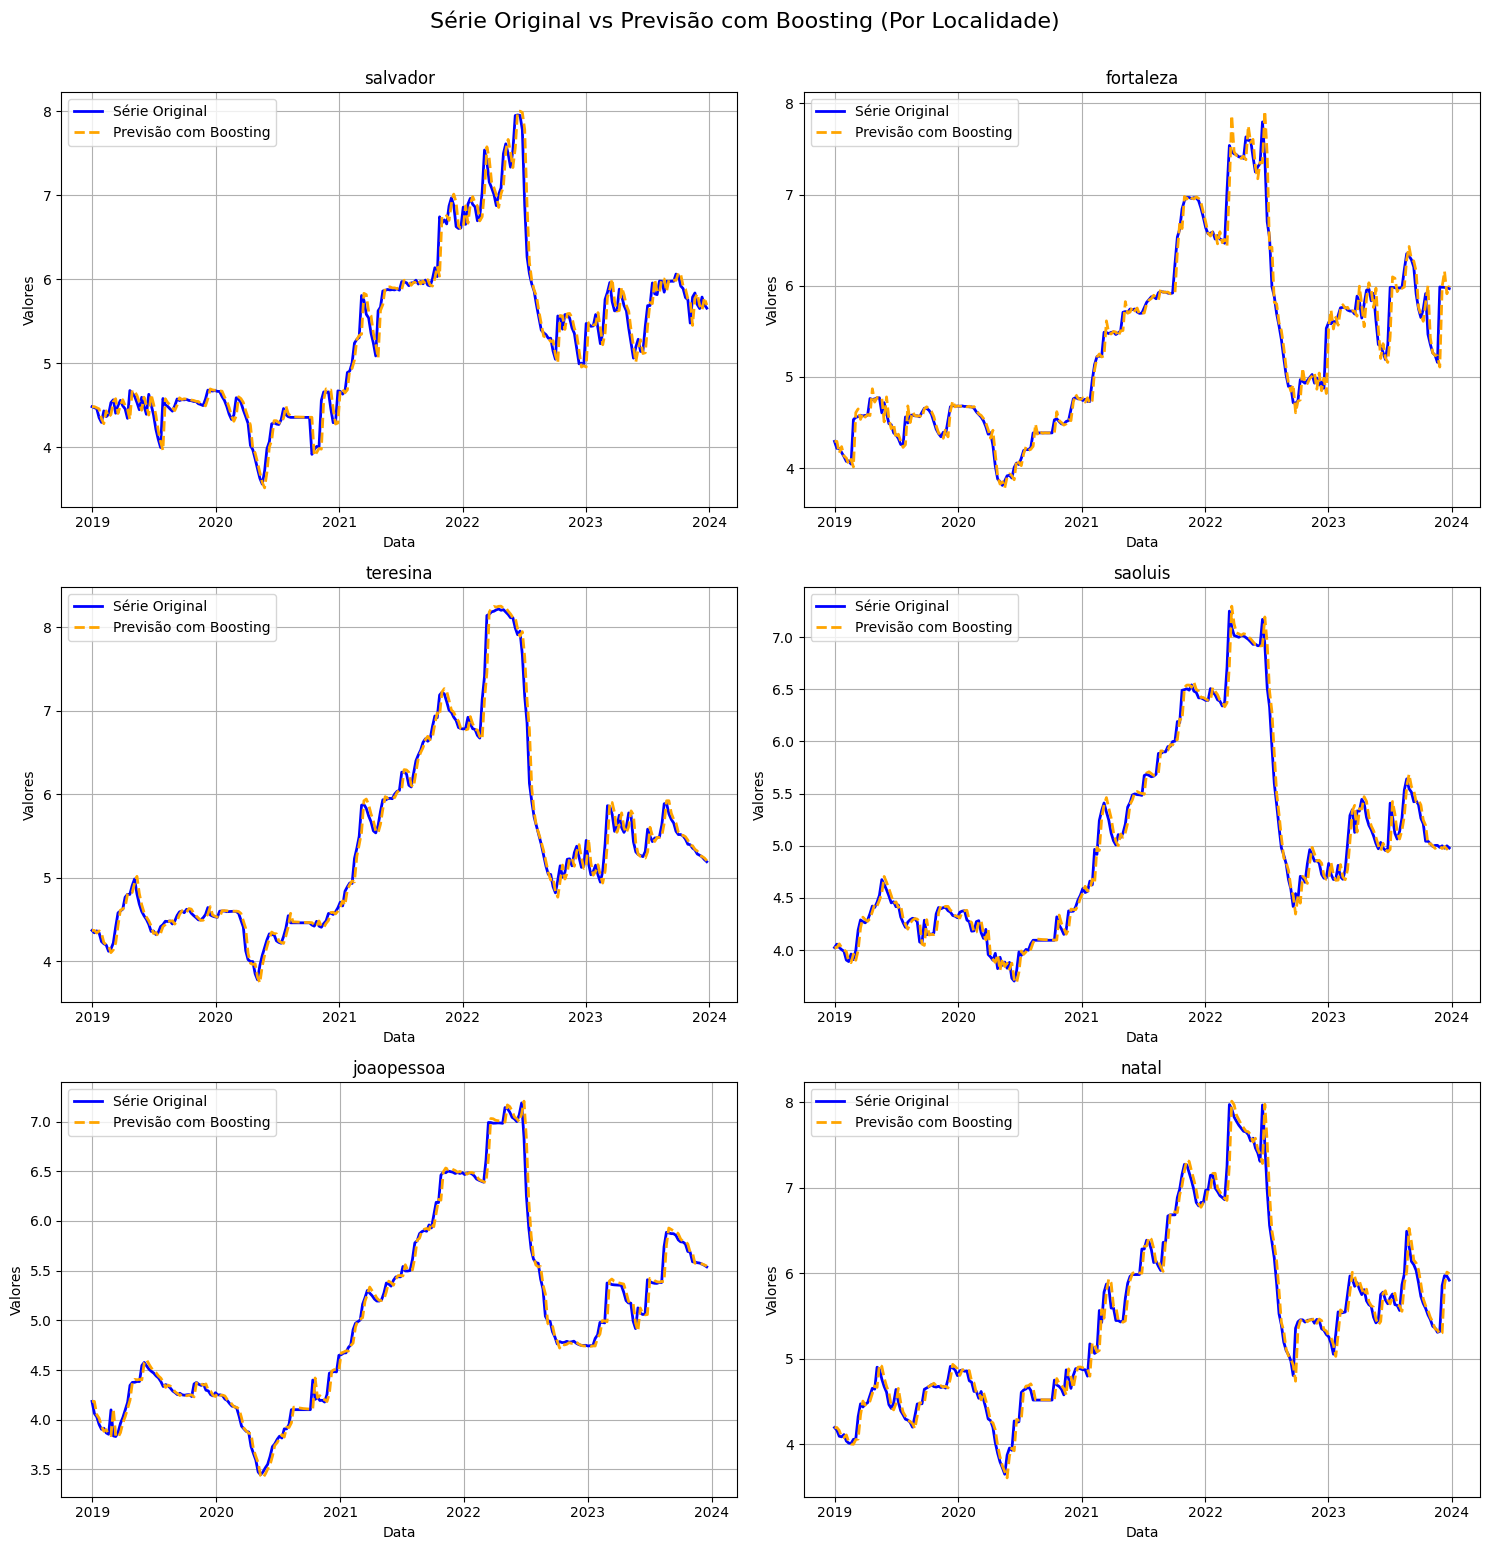

In [12]:
import matplotlib.pyplot as plt

# Configuração para a visualização em grade: 3 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3x2 layout
axes = axes.flatten()  # Achatar para facilitar a iteração

# Localidades e dados correspondentes
localidades = {
    'salvador': (y_salvador, y_forecast_salvador, y_predic_salvador),
    'fortaleza': (y_fortaleza, y_forecast_fortaleza, y_predic_fortaleza),
    'teresina': (y_teresina, y_forecast_teresina, y_predic_teresina),
    'saoluis': (y_saoluis, y_forecast_saoluis, y_predic_saoluis),
    'joaopessoa': (y_joaopessoa, y_forecast_joaopessoa, y_predic_joaopessoa),
    'natal': (y_natal, y_forecast_natal, y_predic_natal)
}

# Dicionário para armazenar as previsões ajustadas (boosted) para cada localidade
y_boosted_forecast_bayes = {}

# Iterar sobre cada localidade para criar os gráficos
for ax, (localidade, (y_true, y_forecast, y_pred_series)) in zip(axes, localidades.items()):
    # Calcular a previsão ajustada com boosting
    y_boosted_forecast = y_forecast + y_pred_series

    # Armazenar as previsões ajustadas no dicionário
    y_boosted_forecast_bayes[localidade] = y_boosted_forecast

    # Plot da série original
    ax.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

    # Plot da previsão ajustada com boosting
    ax.plot(y_pred_series.index, y_boosted_forecast, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

    # Configurações do gráfico
    ax.set_title(localidade)
    ax.set_xlabel('Data')
    ax.set_ylabel('Valores')
    ax.legend()
    ax.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.suptitle('Série Original vs Previsão com Boosting (Por Localidade)', y=1.03, fontsize=16)
plt.show()




In [13]:
y_boosted_forecast_fortaleza_bayes = y_boosted_forecast_bayes['fortaleza']
y_boosted_forecast_natal_bayes = y_boosted_forecast_bayes['natal']
y_boosted_forecast_joaopessoa_bayes = y_boosted_forecast_bayes['joaopessoa']
y_boosted_forecast_salvador_bayes = y_boosted_forecast_bayes['salvador']
y_boosted_forecast_saoluis_bayes = y_boosted_forecast_bayes['saoluis']
y_boosted_forecast_teresina_bayes = y_boosted_forecast_bayes['teresina']


- **Metricas para o modelo NORMA**

  
    - O modelo **NORMA-bayes** apresentou **R²** variando entre **0.967** e **0.986**. Embora esses valores também sejam elevados, o desempenho é ligeiramente inferior ao do **Random Walk** em algumas localidades, como Salvador (0.967) e Fortaleza (0.974). Mesmo assim, os valores de **R²** do **NORMA-bayes** ainda indicam uma boa capacidade explicativa, mas levemente abaixo do **Random Walk**.
    
    - **Índice de Theil** para o modelo **NORMA-bayes** variou entre **1.0** e **1.055**, com valores de **1.019** em **Salvador** e **1.055** em **Fortaleza**. Esses valores indicam que, nessas localidades, o modelo **NORMA-bayes** não conseguiu superar o desempenho de uma simples média. No entanto, para outras localidades como **São Luís**, **João Pessoa** e **Natal**, o **Índice de Theil** ficou próximo de **1.0**, indicando um desempenho razoável, mas não excepcional.

Portanto, em termos de **R²**, o **Random Walk** se saiu melhor, mas em termos de precisão de previsão (Índice de Theil), o **NORMA-bayes** mostrou um desempenho mais variável, com alguns resultados indicando desempenho inferior ao da média.


In [14]:

# Aplicando a função para diferentes localidades
computeAccuracyModels('NORMA-bayes', 'Teresina', y_boosted_forecast_teresina_bayes, y_teresina)
computeAccuracyModels('NORMA-bayes', 'Salvador', y_boosted_forecast_salvador_bayes, y_salvador)
computeAccuracyModels('NORMA-bayes', 'São Luís', y_boosted_forecast_saoluis_bayes, y_saoluis)
computeAccuracyModels('NORMA-bayes', 'João Pessoa', y_boosted_forecast_joaopessoa_bayes, y_joaopessoa)
computeAccuracyModels('NORMA-bayes', 'Fortaleza', y_boosted_forecast_fortaleza_bayes, y_fortaleza)
computeAccuracyModels('NORMA-bayes', 'Natal', y_boosted_forecast_natal_bayes, y_natal)

# Exibindo o DataFrame consolidado
display(df_metrics)

,Localidade,Theil,R2,Modelo
0,Teresina,1.000000,0.985459,Random Walk
1,Salvador,1.000000,0.968224,Random Walk
2,São Luís,1.000000,0.983725,Random Walk
3,João Pessoa,1.000000,0.989240,Random Walk
4,Fortaleza,1.000000,0.975590,Random Walk
5,Natal,1.000000,0.977150,Random Walk
6,Teresina,0.917474,0.986659,NORMA-bayes
7,Salvador,1.019486,0.967605,NORMA-bayes
8,São Luís,0.953636,0.984479,NORMA-bayes
9,João Pessoa,0.929416,0.989999,NORMA-bayes


## 3.2 NORMA-Dictionario

* Nesta seção iremos abordar o modelo norma utilizando a estrutura de dicionário, os melhores hiperparâmetros foram obtidos na abordagem anterior quando usamos busca bayesiana.  
Estes parâmetros foram salvos e serão utilizados na modelagem abaixo, assim teremos as melhores estruturas para cada uma das séries abordadas.  

* No gráfico que vemos a seguir é possivel ver como o modelo previu os residuos randon Walk, é possivel ver que o modelo consegue capturar a tendência porém de forma um pouco atrasada.  
Também é possivel perceber que o modelo não consegue acompanhar quando há picos muito elevados nos valores dos residuos.

In [15]:

# Plote o previsto antes sempre 
# linha do target em preto e previsto em tracejado
# salvar os


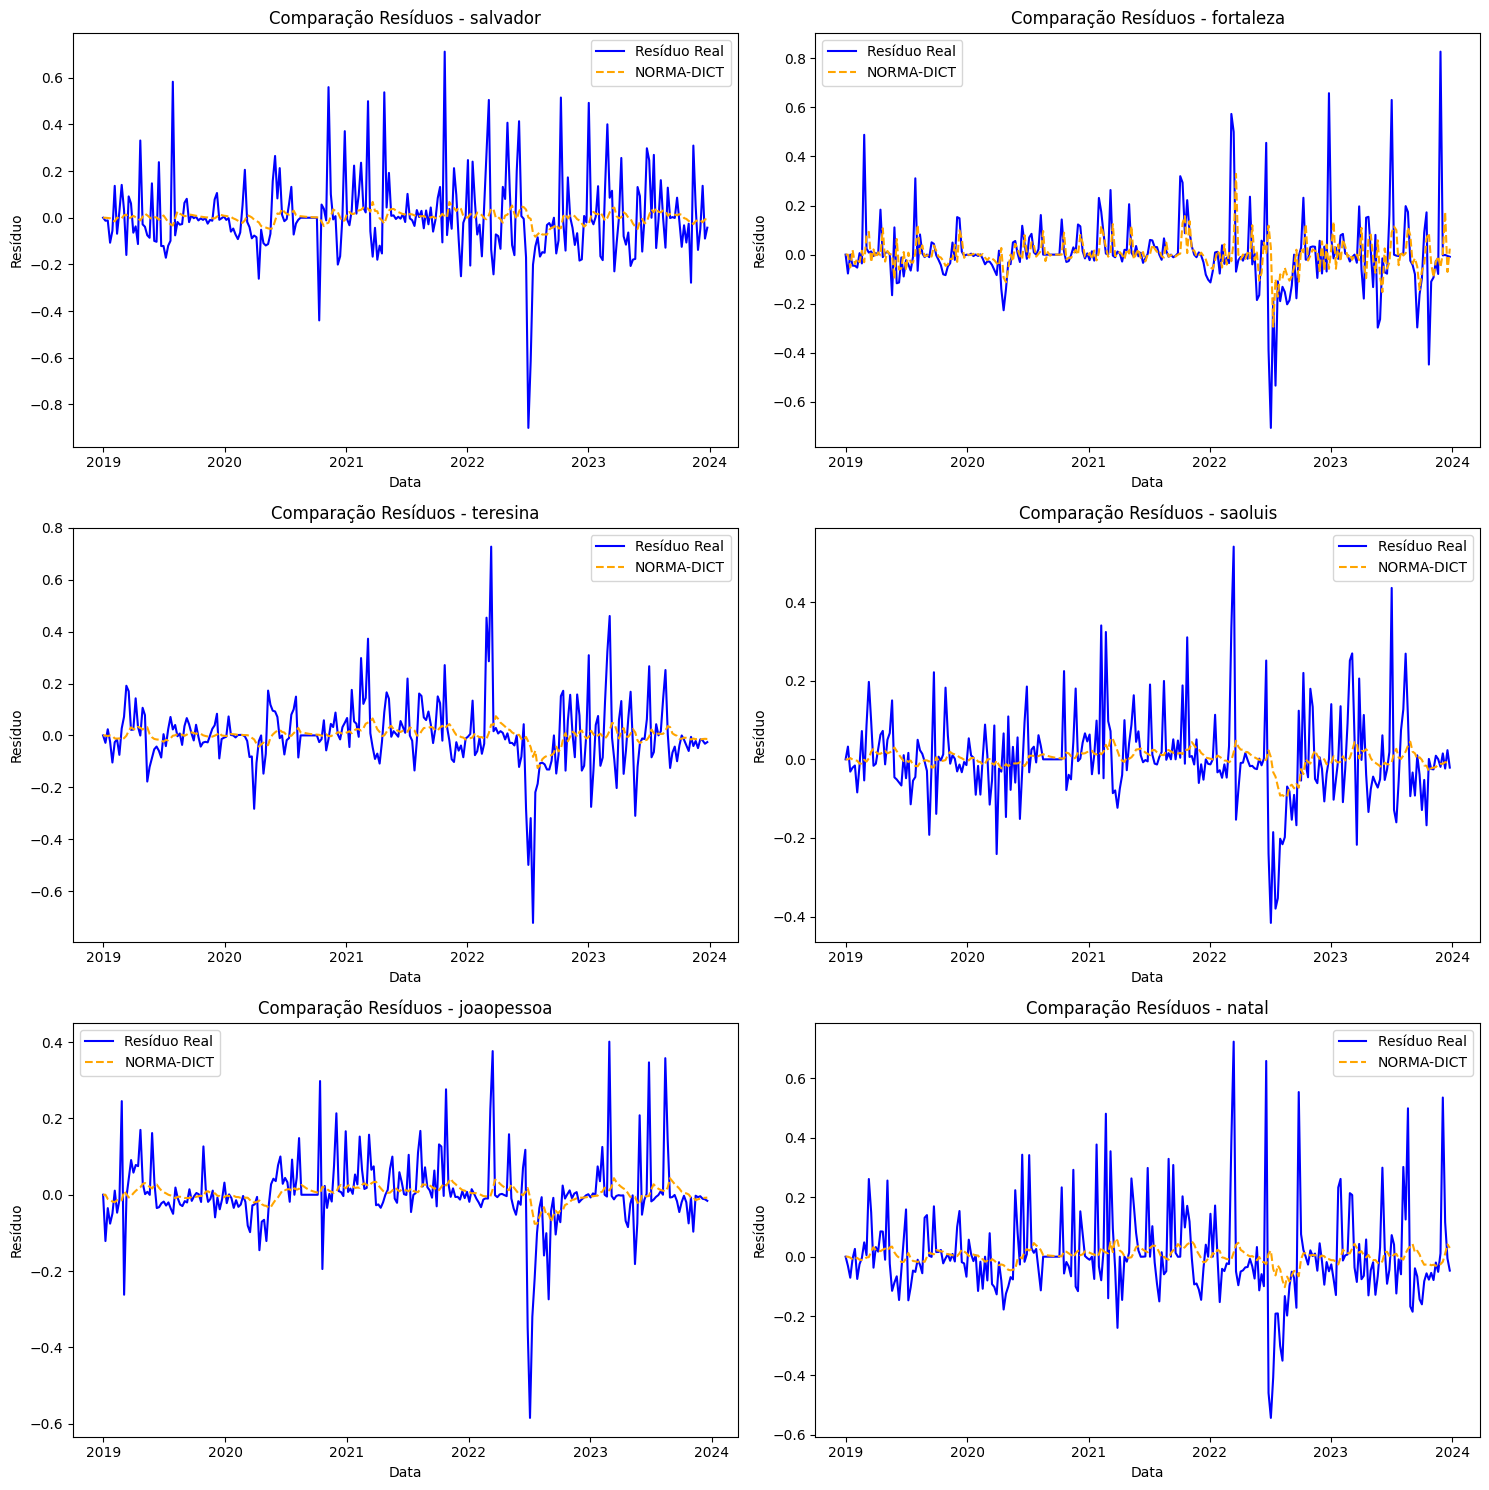

In [16]:
# Cidades e suas respectivas variáveis de X_residual e y_residual
cities = {
    'salvador': (X_residual_salvador, y_residual_salvador),
    'fortaleza': (X_residual_fortaleza, y_residual_fortaleza),
    'teresina': (X_residual_teresina, y_residual_teresina),
    'saoluis': (X_residual_saoluis, y_residual_saoluis),
    'joaopessoa': (X_residual_joaopessoa, y_residual_joaopessoa),
    'natal': (X_residual_natal, y_residual_natal)
}

# Dicionário para armazenar previsões para cada cidade
y_pred_all_cities = {}


# Configurar o layout para múltiplos gráficos
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Criando um grid 2x3 para os gráficos

# Iterar sobre as cidades e gerar os gráficos
for i, (city_name, (X_residual, y_residual)) in enumerate(cities.items()):
    # Aplicar o modelo e obter os resíduos e previsões com os melhores parâmetros
    y_residual_series, y_pred_series = apply_model_and_plot(X_residual, y_residual, best_params_dict[city_name])

    # Armazenar as previsões para a cidade
    y_pred_all_cities[city_name] = y_pred_series

    # Selecionar o eixo correto do gráfico
    ax = axes[i // 2, i % 2]  # Determinar a posição (2x3 grid)
    
    # Plotar os resultados
    ax.plot(y_residual_series, label='Resíduo Real', color='blue')  
    ax.plot(y_pred_series, label='NORMA-DICT', linestyle='--', color='orange')  
    ax.set_title(f'Comparação Resíduos - {city_name}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Resíduo')
    ax.legend()

# Ajustar o layout para que não sobreponha os gráficos
plt.tight_layout()
plt.show()

# Agora, o dicionário best_params_dict contém os melhores parâmetros para cada cidade.
# Esses parâmetros foram utilizados durante a aplicação do modelo para gerar previsões mais precisas.


* Em seguida salvamos as previsões para cada serie de residuos, isto é necessário para a etapa de boosting que será feita a seguir.

In [17]:
y_pred_salvador = y_pred_all_cities['salvador']
y_pred_fortaleza = y_pred_all_cities['fortaleza']
y_pred_joaopessoa = y_pred_all_cities['joaopessoa']
y_pred_natal = y_pred_all_cities['natal']
y_pred_saoluis = y_pred_all_cities['saoluis']
y_pred_teresina= y_pred_all_cities['teresina']


* Na célula abaixo fazemos o boosting para cada serie com a previsão dos residuos feita pelo modelo **NORMA** com abordagem de dicionário, e com a previsão feita pelo modelo **Randon Walk**. 
Também é feita a plotagem para o boosting e o valor de venda original para ser feita a comparação.

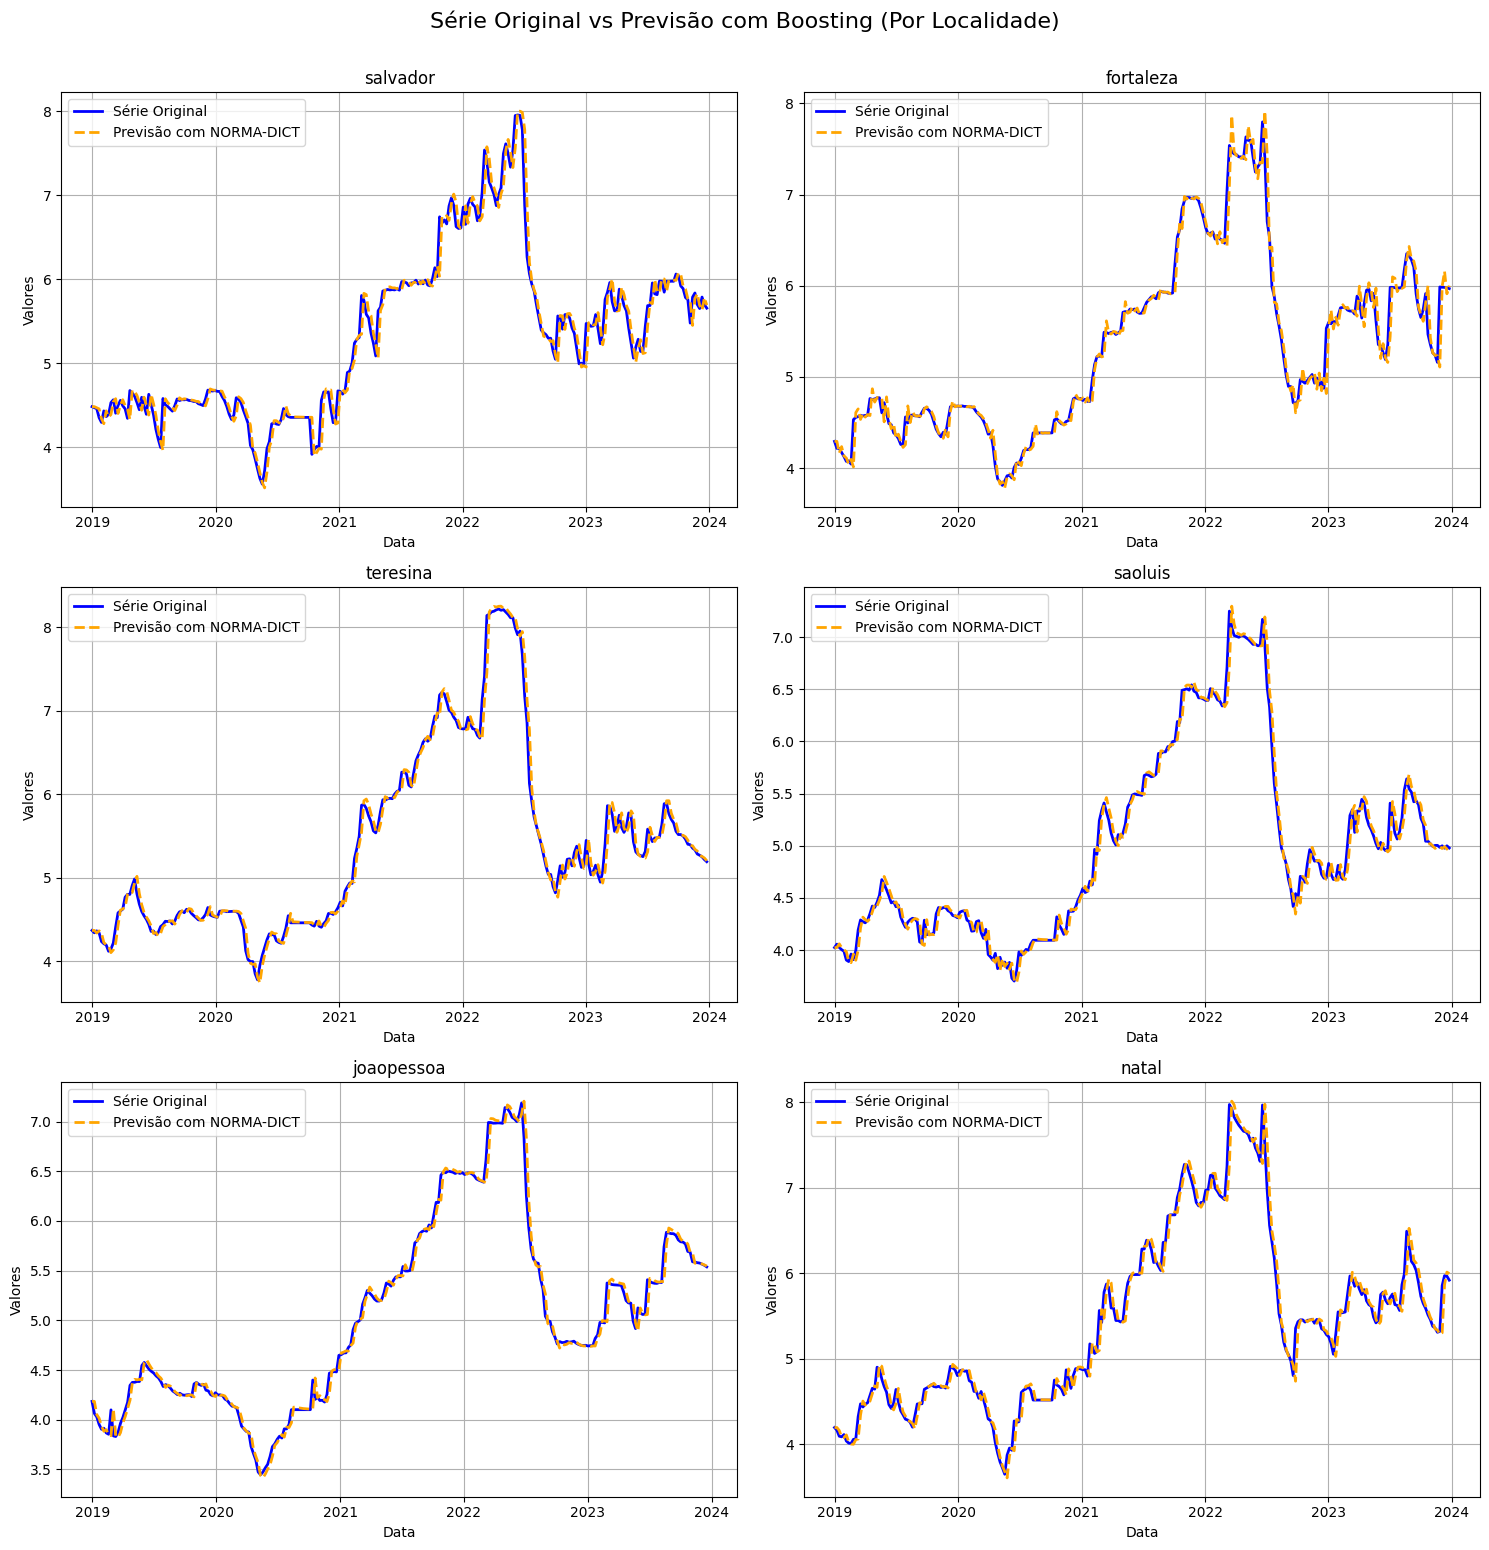

In [18]:
import matplotlib.pyplot as plt

# Configuração para a visualização em grade: 3 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3x2 layout
axes = axes.flatten()  # Achatar para facilitar a iteração

# Localidades e dados correspondentes
localidades = {
    'salvador': (y_salvador, y_forecast_salvador, y_pred_salvador),
    'fortaleza': (y_fortaleza, y_forecast_fortaleza, y_pred_fortaleza),
    'teresina': (y_teresina, y_forecast_teresina, y_pred_teresina),
    'saoluis': (y_saoluis, y_forecast_saoluis, y_pred_saoluis),
    'joaopessoa': (y_joaopessoa, y_forecast_joaopessoa, y_pred_joaopessoa),
    'natal': (y_natal, y_forecast_natal, y_pred_natal)
}

# Dicionário para armazenar as previsões ajustadas (boosted) para cada localidade
y_boosted_forecast_all = {}

# Iterar sobre cada localidade para criar os gráficos
for ax, (localidade, (y_true, y_forecast, y_pred_series)) in zip(axes, localidades.items()):
    # Calcular a previsão ajustada com boosting
    y_boosted_forecast = y_forecast + y_pred_series

    # Armazenar as previsões ajustadas no dicionário
    y_boosted_forecast_all[localidade] = y_boosted_forecast

    # Plot da série original
    ax.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

    # Plot da previsão ajustada com boosting
    ax.plot(y_pred_series.index, y_boosted_forecast, label='Previsão com NORMA-DICT', color='orange', linestyle='--', linewidth=2)

    # Configurações do gráfico
    ax.set_title(localidade)
    ax.set_xlabel('Data')
    ax.set_ylabel('Valores')
    ax.legend()
    ax.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.suptitle('Série Original vs Previsão com Boosting (Por Localidade)', y=1.03, fontsize=16)
plt.show()

#incluir tambem previsao do random walk



* Em seguida o boosting é salvo para cada localidade.

In [19]:
y_boosted_forecast_fortaleza = y_boosted_forecast_all['fortaleza']
y_boosted_forecast_natal = y_boosted_forecast_all['natal']
y_boosted_forecast_joaopessoa = y_boosted_forecast_all['joaopessoa']
y_boosted_forecast_salvador = y_boosted_forecast_all['salvador']
y_boosted_forecast_saoluis = y_boosted_forecast_all['saoluis']
y_boosted_forecast_teresina = y_boosted_forecast_all['teresina']

* **Análise de metricas**


* Comparação NORMA-DICT vs. Random Walk
  * **Métrica Theil**:
   - **NORMA-DICT** apresenta valores de índice de Theil consistentemente melhores que o **Random Walk** para todas as localidades, pois o **Random Walk** apresenta **Theil = 1.0** em todas as localidades.
   - O menor valor de **Theil** do **NORMA-DICT** está em **Teresina** (**0.917474**), indicando uma performance superior ao **Random Walk**.

  * **Métrica \( R^2 \)**:
   - Os valores de \( R^2 \) para o **NORMA-DICT** são ligeiramente superiores ao **Random Walk** em **Teresina**, **São Luís** e **João Pessoa**. Para as outras localidades, as diferenças são pequenas ou nulas.
   - O maior \( R^2 \) do **NORMA-DICT** está em **João Pessoa** (**0.990031**), destacando um ajuste excelente, mas não muito superior ao do **Random Walk**.

* Conclusão:
O **NORMA-DICT** é melhor que o **Random Walk** em ambas as métricas na maioria das localidades.


* Comparação NORMA-DICT vs. NORMA-bayes
  *  **Métrica Theil**:
   - **NORMA-DICT** apresenta os mesmos valores de índice de Theil que o **NORMA-bayes** para todas as localidades. Ambos os modelos são equivalentes segundo essa métrica.

  * **Métrica \( R^2 \)**:
   - Os valores de \( R^2 \) do **NORMA-DICT** são idênticos aos do **NORMA-bayes** em todas as localidades.

* Conclusão:
Praticamente não há diferença entre o **NORMA-DICT** e o **NORMA-bayes**, com ambos performando de maneira equivalente.


* Assim, se percebe que:
- **NORMA-DICT** supera o **Random Walk** em todas as localidades, tanto em **Theil** quanto em \( R^2 \).
- **NORMA-DICT** tem desempenho idêntico ao **NORMA-bayes** em ambas as métricas.


In [20]:
# Aplicando a função para diferentes localidades
computeAccuracyModels('NORMA-DICT', 'Teresina', y_boosted_forecast_teresina, y_teresina)
computeAccuracyModels('NORMA-DICT', 'Salvador', y_boosted_forecast_salvador, y_salvador)
computeAccuracyModels('NORMA-DICT', 'São Luís', y_boosted_forecast_saoluis, y_saoluis)
computeAccuracyModels('NORMA-DICT', 'João Pessoa', y_boosted_forecast_joaopessoa, y_joaopessoa)
computeAccuracyModels('NORMA-DICT', 'Fortaleza', y_boosted_forecast_fortaleza, y_fortaleza)
computeAccuracyModels('NORMA-DICT', 'Natal', y_boosted_forecast_natal, y_natal)

# Exibindo o DataFrame consolidado
display(df_metrics)

# adicionar coluna de modelo

,Localidade,Theil,R2,Modelo
0,Teresina,1.000000,0.985459,Random Walk
1,Salvador,1.000000,0.968224,Random Walk
2,São Luís,1.000000,0.983725,Random Walk
3,João Pessoa,1.000000,0.989240,Random Walk
4,Fortaleza,1.000000,0.975590,Random Walk
5,Natal,1.000000,0.977150,Random Walk
6,Teresina,0.917474,0.986659,NORMA-bayes
7,Salvador,1.019486,0.967605,NORMA-bayes
8,São Luís,0.953636,0.984479,NORMA-bayes
9,João Pessoa,0.929416,0.989999,NORMA-bayes


## 3.3 Arima 

* Explicação da revisão Ponto a Ponto com **ARIMA**.

A previsão ponto a ponto implementada no código utiliza o modelo ARIMA ajustado com a biblioteca `pmdarima` para prever os resíduos de forma incremental. Abaixo estão as etapas e explicações:



* Etapas da Previsão Ponto a Ponto:

* **Treinamento Inicial**:
   - O modelo ARIMA é ajustado inicialmente na série de resíduos completa ($y_{\text{residual}}$) correspondente a cada cidade.
   - A função `pm.auto_arima` encontra os melhores parâmetros $(p, d, q)$ para o modelo com base na série fornecida.

* **Primeira Previsão**:
   - Para o primeiro ponto no tempo ($t=0$), a previsão é simplesmente o valor real observado da série residual, já que não há histórico suficiente para realizar uma previsão.

* **Previsão Iterativa**:
   - A partir do segundo ponto ($t > 0$):
     - **Predição**: O modelo faz uma previsão para o próximo período usando os dados do histórico até aquele momento. A previsão é feita com `model.predict(n_periods=1)[0]`.
     - **Atualização**: Após a previsão, o modelo é atualizado com o valor real observado em $t$ por meio de `model.update(y_{\text{residual}}.iloc[t])`. Essa atualização permite que o modelo incorpore informações do valor real mais recente, ajustando-se dinamicamente à evolução da série.

* **Armazenamento das Previsões**:
   - As previsões ponto a ponto são salvas em uma lista (`predictions_online`) e, ao final, convertidas em uma série (`pd.Series`) com o mesmo índice temporal da série residual real.



* Benefícios da Previsão Ponto a Ponto:
   - **Adaptação Online**: Como o modelo é atualizado com valores reais a cada passo, ele se ajusta dinamicamente às mudanças na série temporal.
   - **Realismo**: Essa abordagem simula como o modelo seria usado em um cenário real, onde apenas os valores passados e observados estariam disponíveis para prever os próximos.



* Limitações:
   - **Depende de Atualizações Frequentes**: O modelo só pode realizar boas previsões se for atualizado regularmente com valores reais.
   - **Custo Computacional**: A atualização do modelo e a previsão em tempo real podem ser computacionalmente intensivas para séries muito longas.



*  Exemplo Intuitivo:
Imagine um viajante que tenta prever o clima de amanhã com base no clima de hoje e dos dias anteriores:
   - Para prever o clima do segundo dia, ele utiliza os dados do primeiro dia (primeira previsão).
   - Quando o segundo dia termina, ele atualiza sua previsão com base no clima observado e tenta prever o terceiro dia, e assim por diante.

No contexto do código, o modelo ARIMA funciona como o "viajante", atualizando suas estimativas com base nos resíduos observados e prevendo o próximo ponto na série temporal.


In [21]:
X_residual_natal= X_residual_natal.drop(columns='Lag_2')
X_residual_fortaleza = X_residual_fortaleza.drop(columns='Lag_2')
X_residual_joaopessoa = X_residual_joaopessoa.drop(columns='Lag_2')
X_residual_teresina = X_residual_teresina.drop(columns='Lag_2')
X_residual_saoluis = X_residual_saoluis.drop(columns='Lag_2')
X_residual_salvador = X_residual_salvador.drop(columns='Lag_2')

* Utilizamos o modelo **ARIMA** fornecido pela biblioteca `pmdarima`, que é projetado para identificar automaticamente a melhor configuração de parâmetros do modelo **ARIMA** (AutoRegressive Integrated Moving Average) para cada série temporal analisada. Essa abordagem automatizada otimiza os valores de $p$, $d$, e $q$, garantindo a seleção de uma arquitetura que equilibre desempenho e precisão preditiva de forma eficiente.  

* Em seguida é feita a plotagem da previsão dos residuos do **Randon Walk** para cada serie, també é mostrado a melhor configuração encontrada para cada série.

C:\Users\kaio\AppData\Local\Temp\ipykernel_28404\2591519780.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediction = model.predict(n_periods=1)[0]  # Prever um período
C:\Users\kaio\AppData\Local\Temp\ipykernel_28404\2591519780.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediction = model.predict(n_periods=1)[0]  # Prever um período
C:\Users\kaio\AppData\Local\Temp\ipykernel_28404\2591519780.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

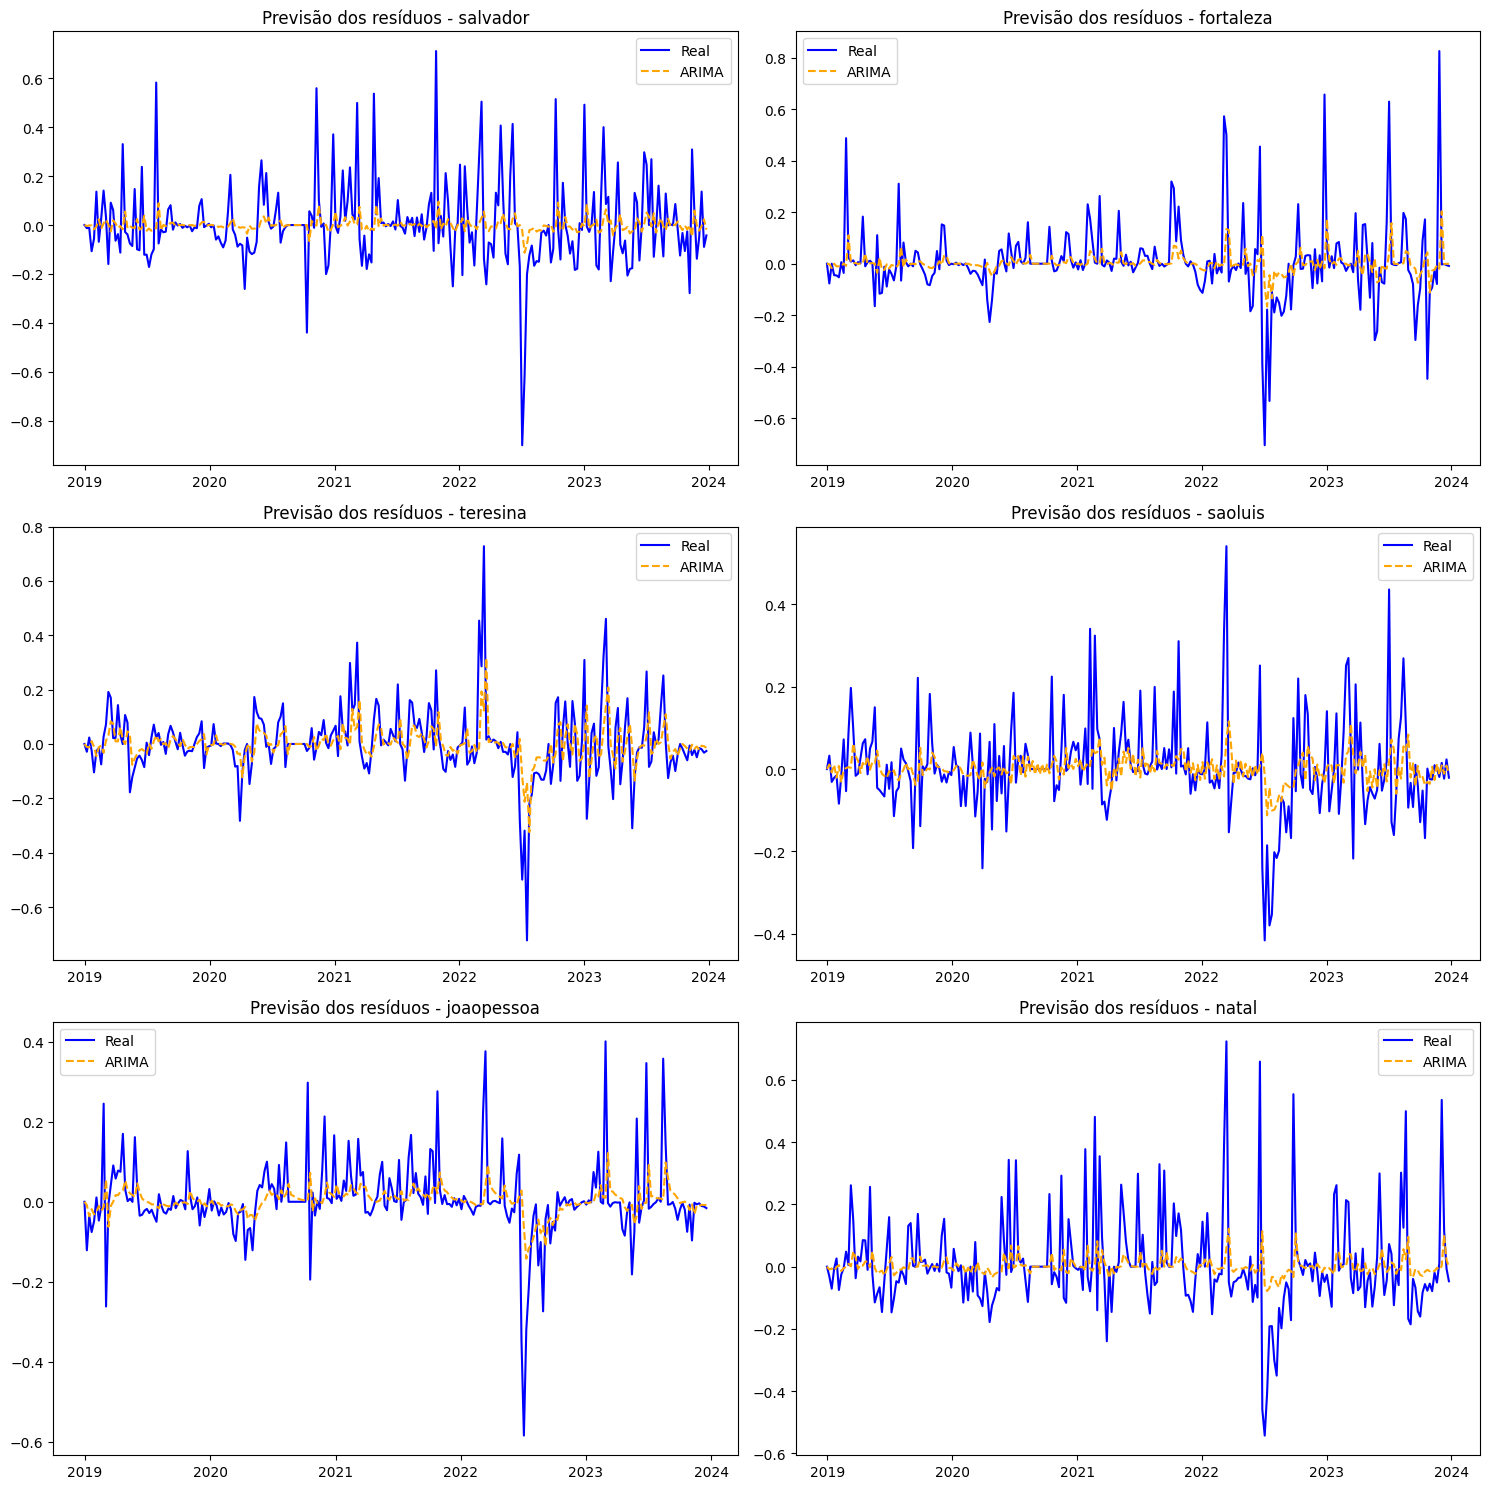

salvador: ARIMA(0, 0, 1)
fortaleza: ARIMA(1, 0, 0)
teresina: ARIMA(1, 0, 0)
saoluis: ARIMA(2, 0, 2)
joaopessoa: ARIMA(1, 0, 2)
natal: ARIMA(1, 0, 0)


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm

# Dados simulados (substitua pelas suas cidades reais)
cities = {
    'salvador': (X_residual_salvador, y_residual_salvador),
    'fortaleza': (X_residual_fortaleza, y_residual_fortaleza),
    'teresina': (X_residual_teresina, y_residual_teresina),
    'saoluis': (X_residual_saoluis, y_residual_saoluis),
    'joaopessoa': (X_residual_joaopessoa, y_residual_joaopessoa),
    'natal': (X_residual_natal, y_residual_natal)
}

predictions = {}
model_architectures = {}  # Dicionário para salvar as arquiteturas dos modelos

# Iterar sobre as cidades
for city, (X_residual, y_residual) in cities.items():
    # Inicializar o modelo AutoARIMA
    model = pm.auto_arima(
        y_residual,  # Série residual para inicializar o modelo
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        trace=False
    )

    # Salvar a arquitetura do modelo
    model_architectures[city] = model.order

    predictions_online = []  # Lista para armazenar previsões

    # Previsão online ponto a ponto
    for t in range(len(y_residual)):
        if t == 0:
            # Primeira previsão é o valor real
            predictions_online.append(y_residual.iloc[t])
        else:
            prediction = model.predict(n_periods=1)[0]  # Prever um período
            predictions_online.append(prediction)
            model.update(y_residual.iloc[t])  # Atualizar com valor real pela posição

    # Armazenar previsões
    predictions[city] = pd.Series(predictions_online, index=y_residual.index)

# Configurar os subplots em grade
num_cities = len(cities)
cols = 2  # Número de colunas na grade
rows = (num_cities + cols - 1) // cols  # Número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=False, sharey=False)

# Iterar sobre as cidades e plotar os gráficos
for i, (city, preds) in enumerate(predictions.items()):
    row, col = divmod(i, cols)
    ax = axes[row, col] if rows > 1 else axes[col]  # Selecionar o eixo correto
    ax.plot(cities[city][1], label='Real', color='blue')
    ax.plot(preds, label='ARIMA', linestyle='--', color='orange')
    ax.set_title(f'Previsão dos resíduos - {city}')
    ax.legend()

# Remover subplots vazios (se houver)
if num_cities < rows * cols:
    for i in range(num_cities, rows * cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


# Exibir as arquiteturas no console
for city, order in model_architectures.items():
    print(f"{city}: ARIMA{order}")


Abaixo salvamos a predição feita para os residuos.

In [23]:
y_predic_salvador_arima = predictions['salvador']
y_predic_natal_arima = predictions['natal']
y_predic_fortaleza_arima = predictions['fortaleza']
y_predic_teresina_arima= predictions['teresina']
y_predic_saoluis_arima = predictions['saoluis']
y_predic_joaopessoa_arima = predictions['joaopessoa']
        

* Logo abaixo é feita o boosting com a previsão dos residuos feita pelo modelo arima e a previsão do modelo **Randon Walk**.   
Também mostramos a plotagem da previsão com boosting em comparação com a série orignal de `Valor de Venda`.

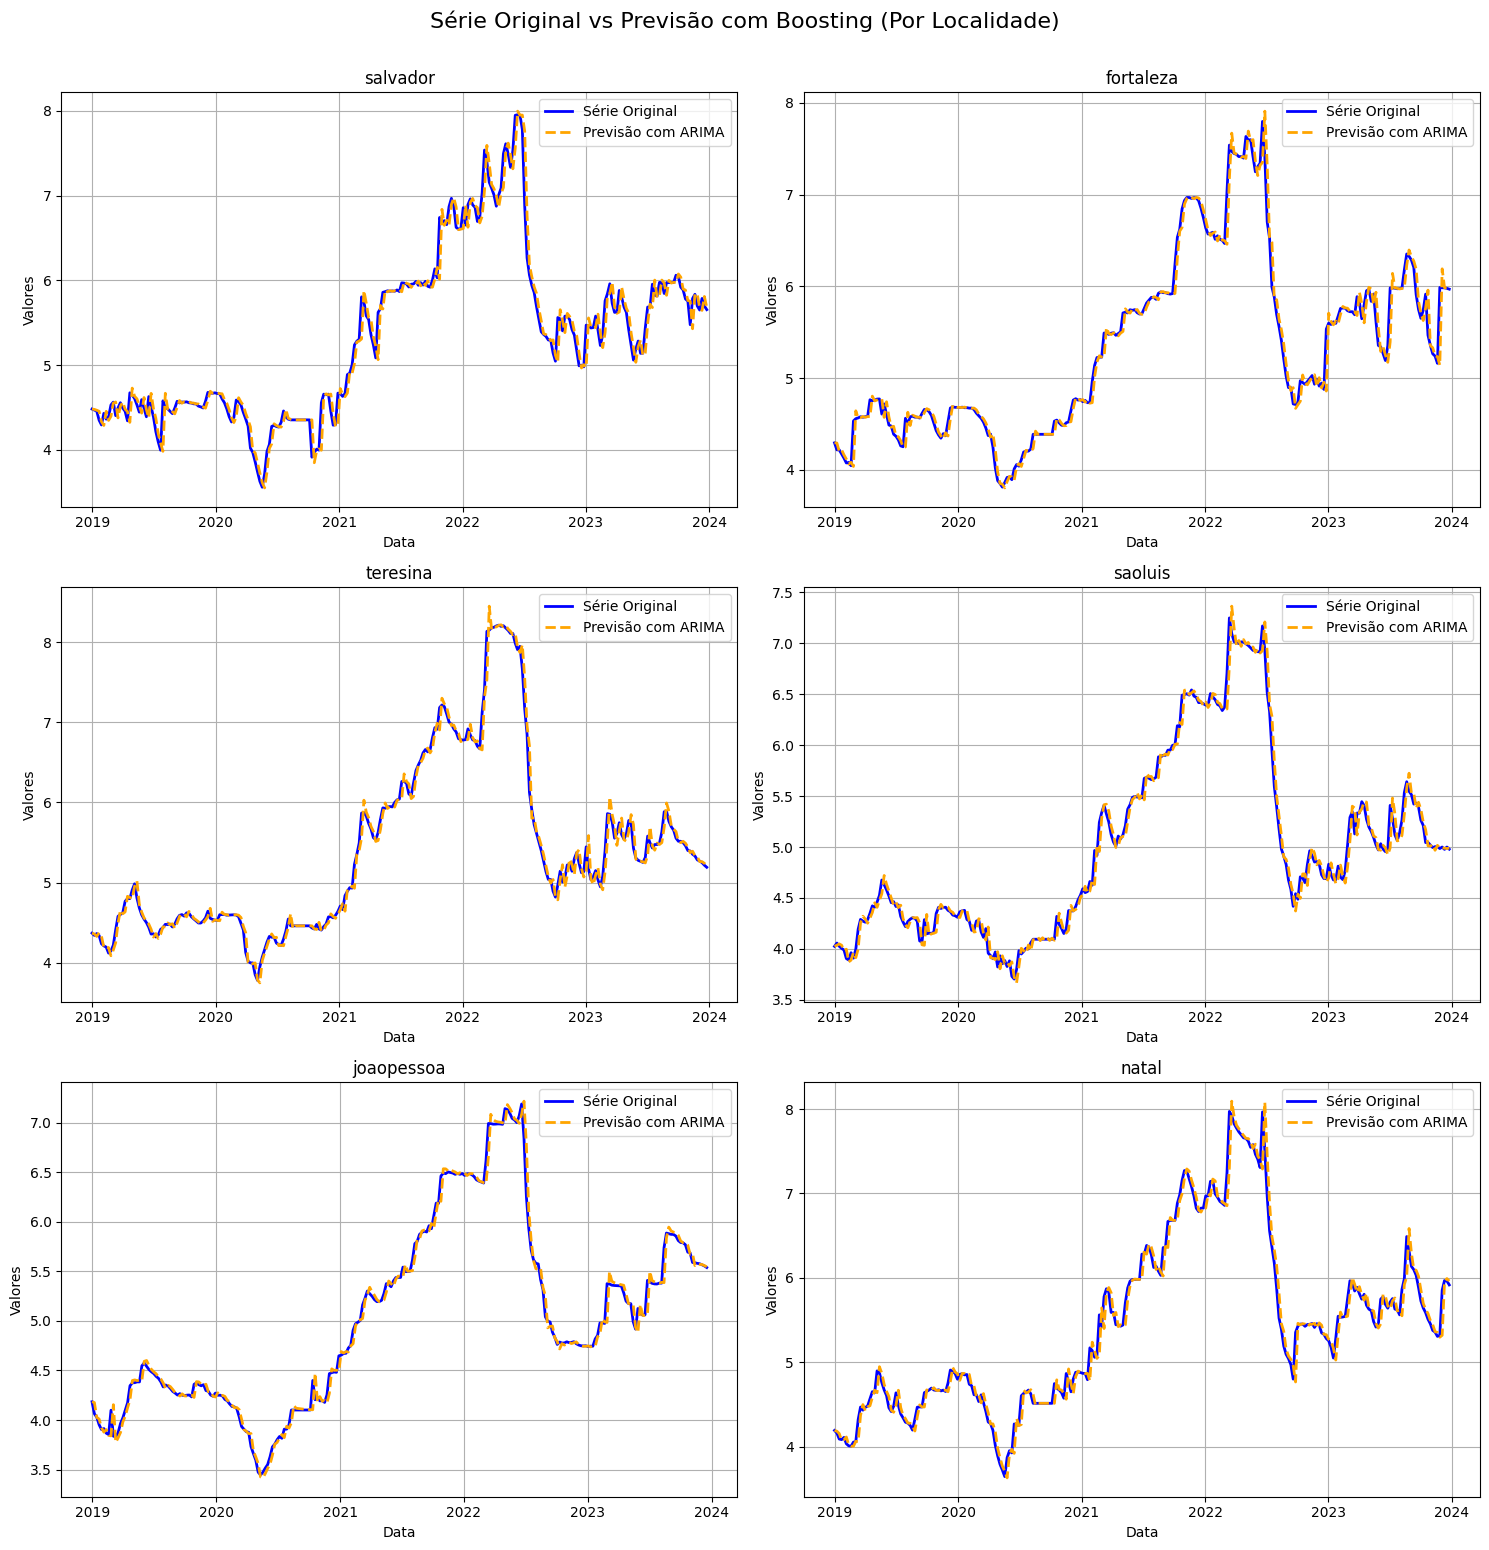

In [24]:
import matplotlib.pyplot as plt

# Configuração para a visualização em grade: 3 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3x2 layout
axes = axes.flatten()  # Achatar para facilitar a iteração

# Localidades e dados correspondentes
localidades = {
    'salvador': (y_salvador, y_forecast_salvador, y_predic_salvador_arima),
    'fortaleza': (y_fortaleza, y_forecast_fortaleza, y_predic_fortaleza_arima),
    'teresina': (y_teresina, y_forecast_teresina, y_predic_teresina_arima),
    'saoluis': (y_saoluis, y_forecast_saoluis, y_predic_saoluis_arima),
    'joaopessoa': (y_joaopessoa, y_forecast_joaopessoa, y_predic_joaopessoa_arima),
    'natal': (y_natal, y_forecast_natal, y_predic_natal_arima)
}

# Dicionário para armazenar as previsões ajustadas (boosted) para cada localidade
y_boosted_forecast_arima = {}

# Iterar sobre cada localidade para criar os gráficos
for ax, (localidade, (y_true, y_forecast, y_pred_series)) in zip(axes, localidades.items()):
    # Calcular a previsão ajustada com boosting
    y_boosted_forecast = y_forecast + y_pred_series

    # Armazenar as previsões ajustadas no dicionário
    y_boosted_forecast_arima[localidade] = y_boosted_forecast

    # Plot da série original
    ax.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

    # Plot da previsão ajustada com boosting
    ax.plot(y_pred_series.index, y_boosted_forecast, label='Previsão com ARIMA', color='orange', linestyle='--', linewidth=2)

    # Configurações do gráfico
    ax.set_title(localidade)
    ax.set_xlabel('Data')
    ax.set_ylabel('Valores')
    ax.legend()
    ax.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.suptitle('Série Original vs Previsão com Boosting (Por Localidade)', y=1.03, fontsize=16)
plt.show()




* Nas celulas abaixo salvamos o boosting feito para cada serie.

In [25]:
y_boosted_forecast_fortaleza_arima = y_boosted_forecast_arima['fortaleza']
y_boosted_forecast_natal_arima = y_boosted_forecast_arima['natal']
y_boosted_forecast_joaopessoa_arima = y_boosted_forecast_arima['joaopessoa']
y_boosted_forecast_salvador_arima = y_boosted_forecast_arima['salvador']
y_boosted_forecast_saoluis_arima = y_boosted_forecast_arima['saoluis']
y_boosted_forecast_teresina_arima = y_boosted_forecast_arima['teresina']


* **Análise das meticas de desempenho**

* Comparação ARIMA vs. Random Walk
  * **Métrica Theil**:
   - O modelo **ARIMA** apresenta índices de Theil inferiores ao **Random Walk** em todas as localidades, indicando que o **ARIMA** tem melhor capacidade preditiva.
   - O menor índice de Theil do **ARIMA** ocorre em **Teresina** (**0.815032**), enquanto o **Random Walk** tem índice de Theil igual a **1.0** em todas as localidades.

  * **Métrica \( R^2 \)**:
   - Os valores de \( R^2 \) do **ARIMA** são ligeiramente superiores ao **Random Walk** em todas as localidades, confirmando seu melhor desempenho.

* Conclusão:
   - **ARIMA** supera claramente o **Random Walk** nas duas métricas em todas as localidades.


* Comparação ARIMA vs. NORMA-bayes/NORMA-DICT
  * **Métrica Theil**:
   - O modelo **ARIMA** apresenta melhores índices de Theil em quatro localidades:
     - **Teresina**: **0.815032** (melhor entre todos os modelos).
     - **São Luís**: **0.930608** (menor que o **NORMA-bayes/DICT** em **0.020277**).
     - **João Pessoa**: **0.900196** (melhor entre todos os modelos).
     - **Fortaleza**: **0.952430** (melhor que o **NORMA-bayes/DICT**).

   - Em **Salvador** e **Natal**, os índices de Theil do **ARIMA** são competitivos, mas ligeiramente piores que os do **NORMA-DICT**/**NORMA-bayes**.

  * Métrica \( R^2 \)**:
   - O modelo **ARIMA** tem os melhores \( R^2 \) em três localidades:
     - **Teresina**: \( R^2 = 0.988149 \).
     - **João Pessoa**: \( R^2 = 0.990314 \).
     - **São Luís**: \( R^2 = 0.984854 \).
   - Para as demais localidades (**Salvador**, **Fortaleza**, e **Natal**), o \( R^2 \) do **ARIMA** é semelhante ao dos modelos **NORMA**.

* Conclusão:
O **ARIMA** tem desempenho superior ou equivalente ao **NORMA-bayes**/**NORMA-DICT** na maioria das localidades, especialmente em **Teresina** e **João Pessoa**, onde apresenta os melhores resultados.

*  Resumo Geral: Melhor Modelo
    - O modelo **ARIMA** tem o melhor desempenho geral, superando tanto o **Random Walk** quanto os modelos **NORMA** na maioria das localidades, especialmente nas métricas de **Theil**.
    - O desempenho do **ARIMA** é consistentemente bom em todas as localidades, com destaque para **Teresina** e **João Pessoa**, onde domina em ambas as métricas.


In [26]:

# Aplicando a função para diferentes localidades
computeAccuracyModels('ARIMA', 'Teresina', y_boosted_forecast_teresina_arima, y_teresina)
computeAccuracyModels('ARIMA', 'Salvador', y_boosted_forecast_salvador_arima, y_salvador)
computeAccuracyModels('ARIMA', 'São Luís', y_boosted_forecast_saoluis_arima, y_saoluis)
computeAccuracyModels('ARIMA', 'João Pessoa', y_boosted_forecast_joaopessoa_arima, y_joaopessoa)
computeAccuracyModels('ARIMA', 'Fortaleza', y_boosted_forecast_fortaleza_arima, y_fortaleza)
computeAccuracyModels('ARIMA', 'Natal', y_boosted_forecast_natal_arima, y_natal)

# Exibindo o DataFrame consolidado
display(df_metrics)

,Localidade,Theil,R2,Modelo
0,Teresina,1.000000,0.985459,Random Walk
1,Salvador,1.000000,0.968224,Random Walk
2,São Luís,1.000000,0.983725,Random Walk
3,João Pessoa,1.000000,0.989240,Random Walk
4,Fortaleza,1.000000,0.975590,Random Walk
5,Natal,1.000000,0.977150,Random Walk
6,Teresina,0.917474,0.986659,NORMA-bayes
7,Salvador,1.019486,0.967605,NORMA-bayes
8,São Luís,0.953636,0.984479,NORMA-bayes
9,João Pessoa,0.929416,0.989999,NORMA-bayes


## 3.4 Arima River

Nesta etapa, utilizamos o modelo **ARIMA** da biblioteca **river** para realizar previsões dos resíduos de forma incremental e online. A biblioteca **river** é especializada em aprendizado online, permitindo que os modelos sejam atualizados continuamente com novos dados sem a necessidade de um retrabalho completo.

As configurações e arquiteturas previamente ajustadas pela biblioteca **pmdarima**, que determinam os parâmetros ótimos do modelo ARIMA $(p, d, q)$, são reaproveitadas na implementação do modelo **ARIMA** da biblioteca **river**. Essa abordagem garante que o modelo da **river** seja configurado de forma eficiente, aproveitando os resultados de uma análise inicial offline com o **pmdarima**, enquanto explora os benefícios do aprendizado online.

**Funcionamento da Previsão Online:**

* **Configuração Inicial**:
   - Para cada série de resíduos, configuramos um modelo **ARIMA** na biblioteca **river** utilizando os parâmetros $(p, d, q)$ obtidos pela análise com **pmdarima**.

* **Previsão Incremental**:
   - A previsão é feita ponto a ponto, com o modelo atualizando continuamente seu estado interno conforme novos valores reais da série residual são disponibilizados.
   - Em cada passo:
     - O modelo utiliza os dados disponíveis até o momento para prever o próximo ponto.
     - Após a previsão, o modelo é atualizado com o valor real observado.

* **Adaptação ao Cenário Online**:
   - Diferentemente da abordagem tradicional offline, o modelo não precisa reprocessar toda a série de dados ao receber novas informações, tornando o processo mais eficiente para séries temporais em fluxo contínuo.

**Benefícios do Uso da Biblioteca river:**

- **Aprendizado Contínuo**: A biblioteca **river** permite a atualização incremental do modelo, o que é essencial em cenários de aprendizado online.
- **Eficiência Computacional**: Apenas os dados mais recentes são processados a cada atualização, reduzindo o custo computacional em comparação com métodos offline.
- **Escalabilidade**: Ideal para lidar com séries temporais extensas ou em constante crescimento, como dados de sensores ou fluxos de dados em tempo real.



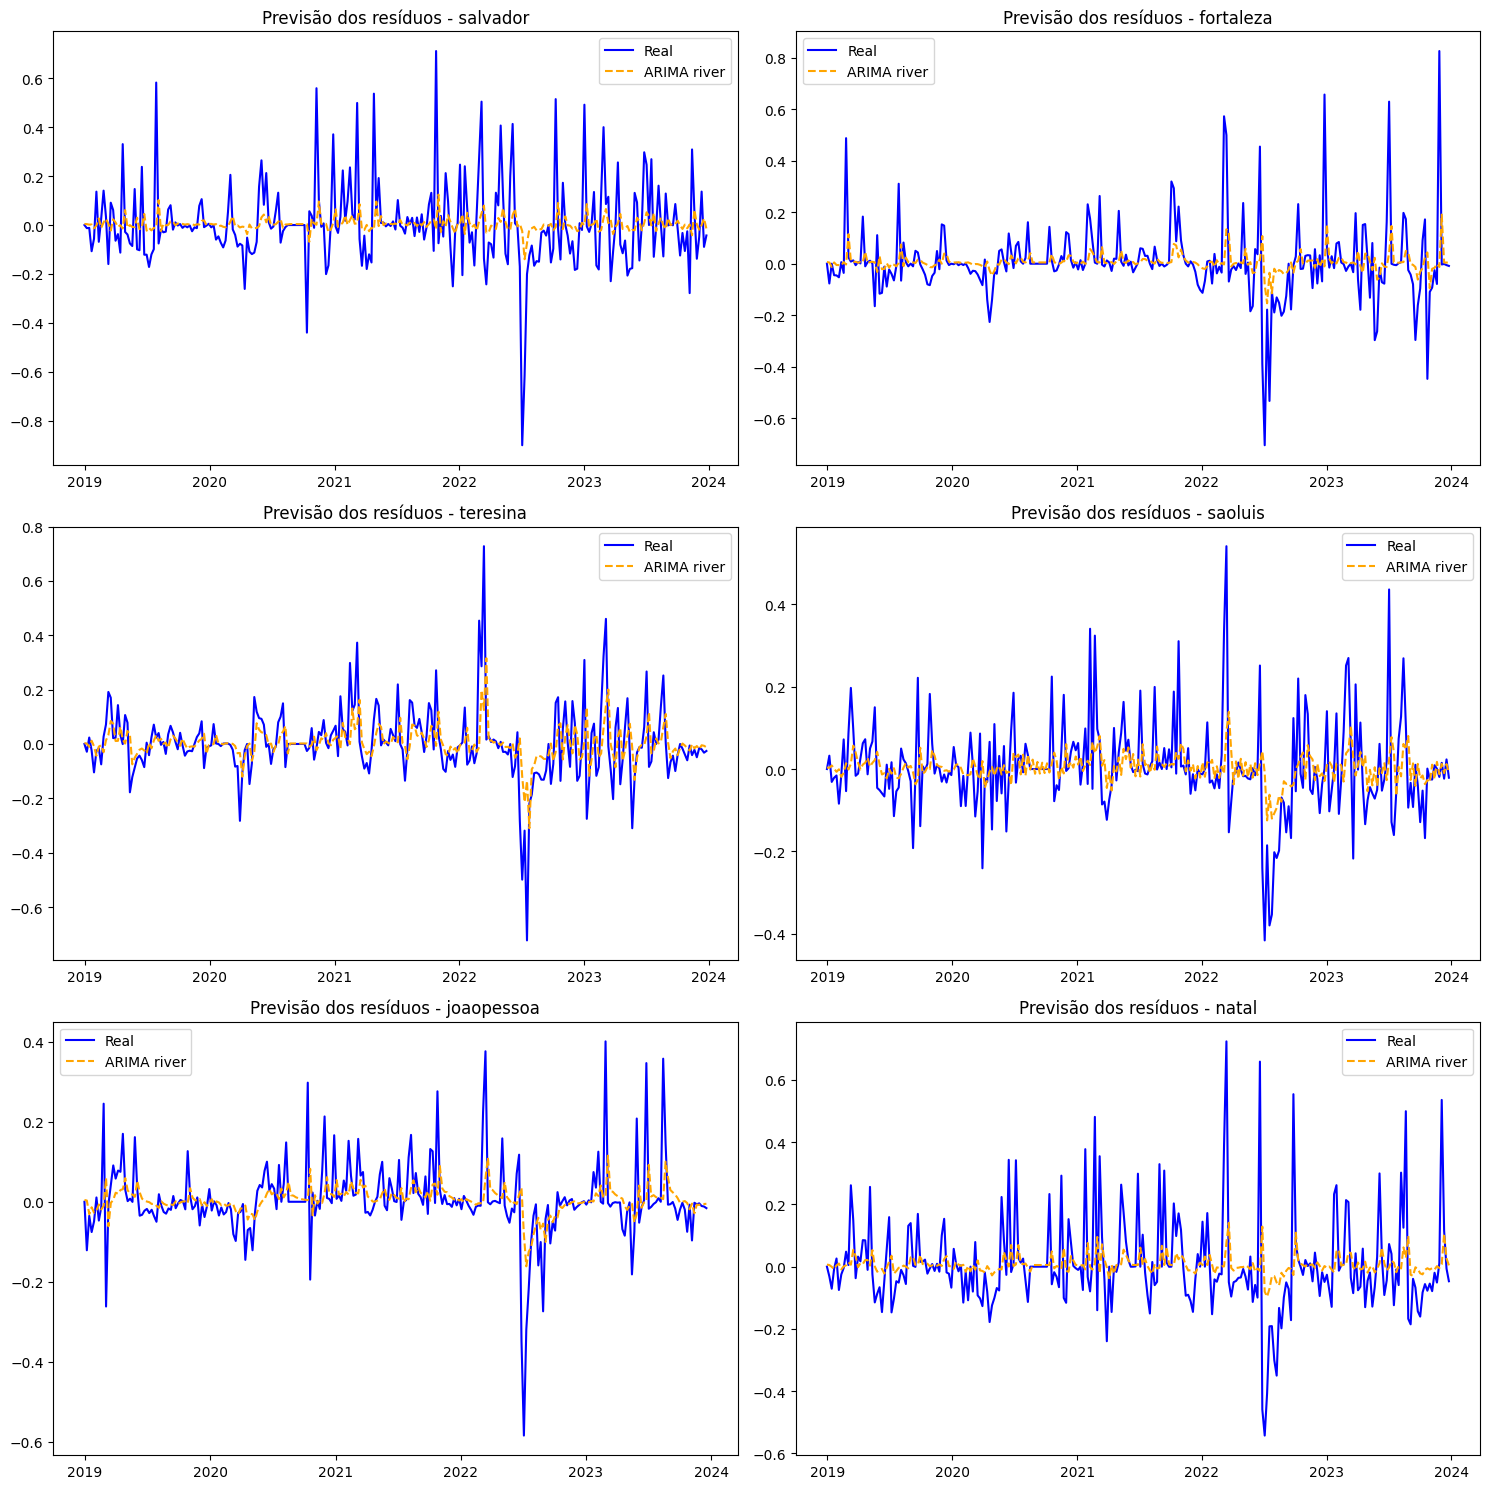

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima import ARIMA

# Dados residuais para cada cidade (substitua pelos seus dados reais)
cities = {
    'salvador': (X_residual_salvador, y_residual_salvador),
    'fortaleza': (X_residual_fortaleza, y_residual_fortaleza),
    'teresina': (X_residual_teresina, y_residual_teresina),
    'saoluis': (X_residual_saoluis, y_residual_saoluis),
    'joaopessoa': (X_residual_joaopessoa, y_residual_joaopessoa),
    'natal': (X_residual_natal, y_residual_natal)
}

predictions = {}

# Iterar sobre as cidades
for city, (X_residual, y_residual) in cities.items():
    # Obter a configuração ARIMA diretamente do dicionário
    arima_order = model_architectures[city]
    
    # Configurar modelo ARIMA com os parâmetros definidos no dicionário
    model = ARIMA(
        order=arima_order,
        suppress_warnings=True  # Evita mensagens desnecessárias
    )
    
    # Ajustar o modelo aos dados residuais
    model.fit(y_residual)

    # Fazer previsões para todo o conjunto de dados
    predictions[city] = pd.Series(model.predict_in_sample(), index=y_residual.index)

# Configurar os subplots em grade
num_cities = len(cities)
cols = 2  # Número de colunas na grade
rows = (num_cities + cols - 1) // cols  # Número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=False, sharey=False)

# Iterar sobre as cidades e plotar os gráficos
for i, (city, preds) in enumerate(predictions.items()):
    row, col = divmod(i, cols)
    ax = axes[row, col] if rows > 1 else axes[col]  # Selecionar o eixo correto
    ax.plot(cities[city][1], label='Real', color='blue')
    ax.plot(preds, label='ARIMA river', linestyle='--', color='orange')
    ax.set_title(f'Previsão dos resíduos - {city}')
    ax.legend()

# Remover subplots vazios (se houver)
if num_cities < rows * cols:
    for i in range(num_cities, rows * cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()




* Em seguida salvamos a predição dos residuos para cada localidade.

In [28]:
y_predic_salvador_arima_river = predictions['salvador']
y_predic_natal_river = predictions['natal']
y_predic_fortaleza_river = predictions['fortaleza']
y_predic_teresina_river = predictions['teresina']
y_predic_saoluis_river = predictions['saoluis']
y_predic_joaopessoa_river = predictions['joaopessoa']
        

* Nesta etapa é feito o boosting com a previsão dos residuos feita pelo modelo **ARIMA** da biblioteca **river** e a previsao original da serie feita com o modelo **Randon Walk**.

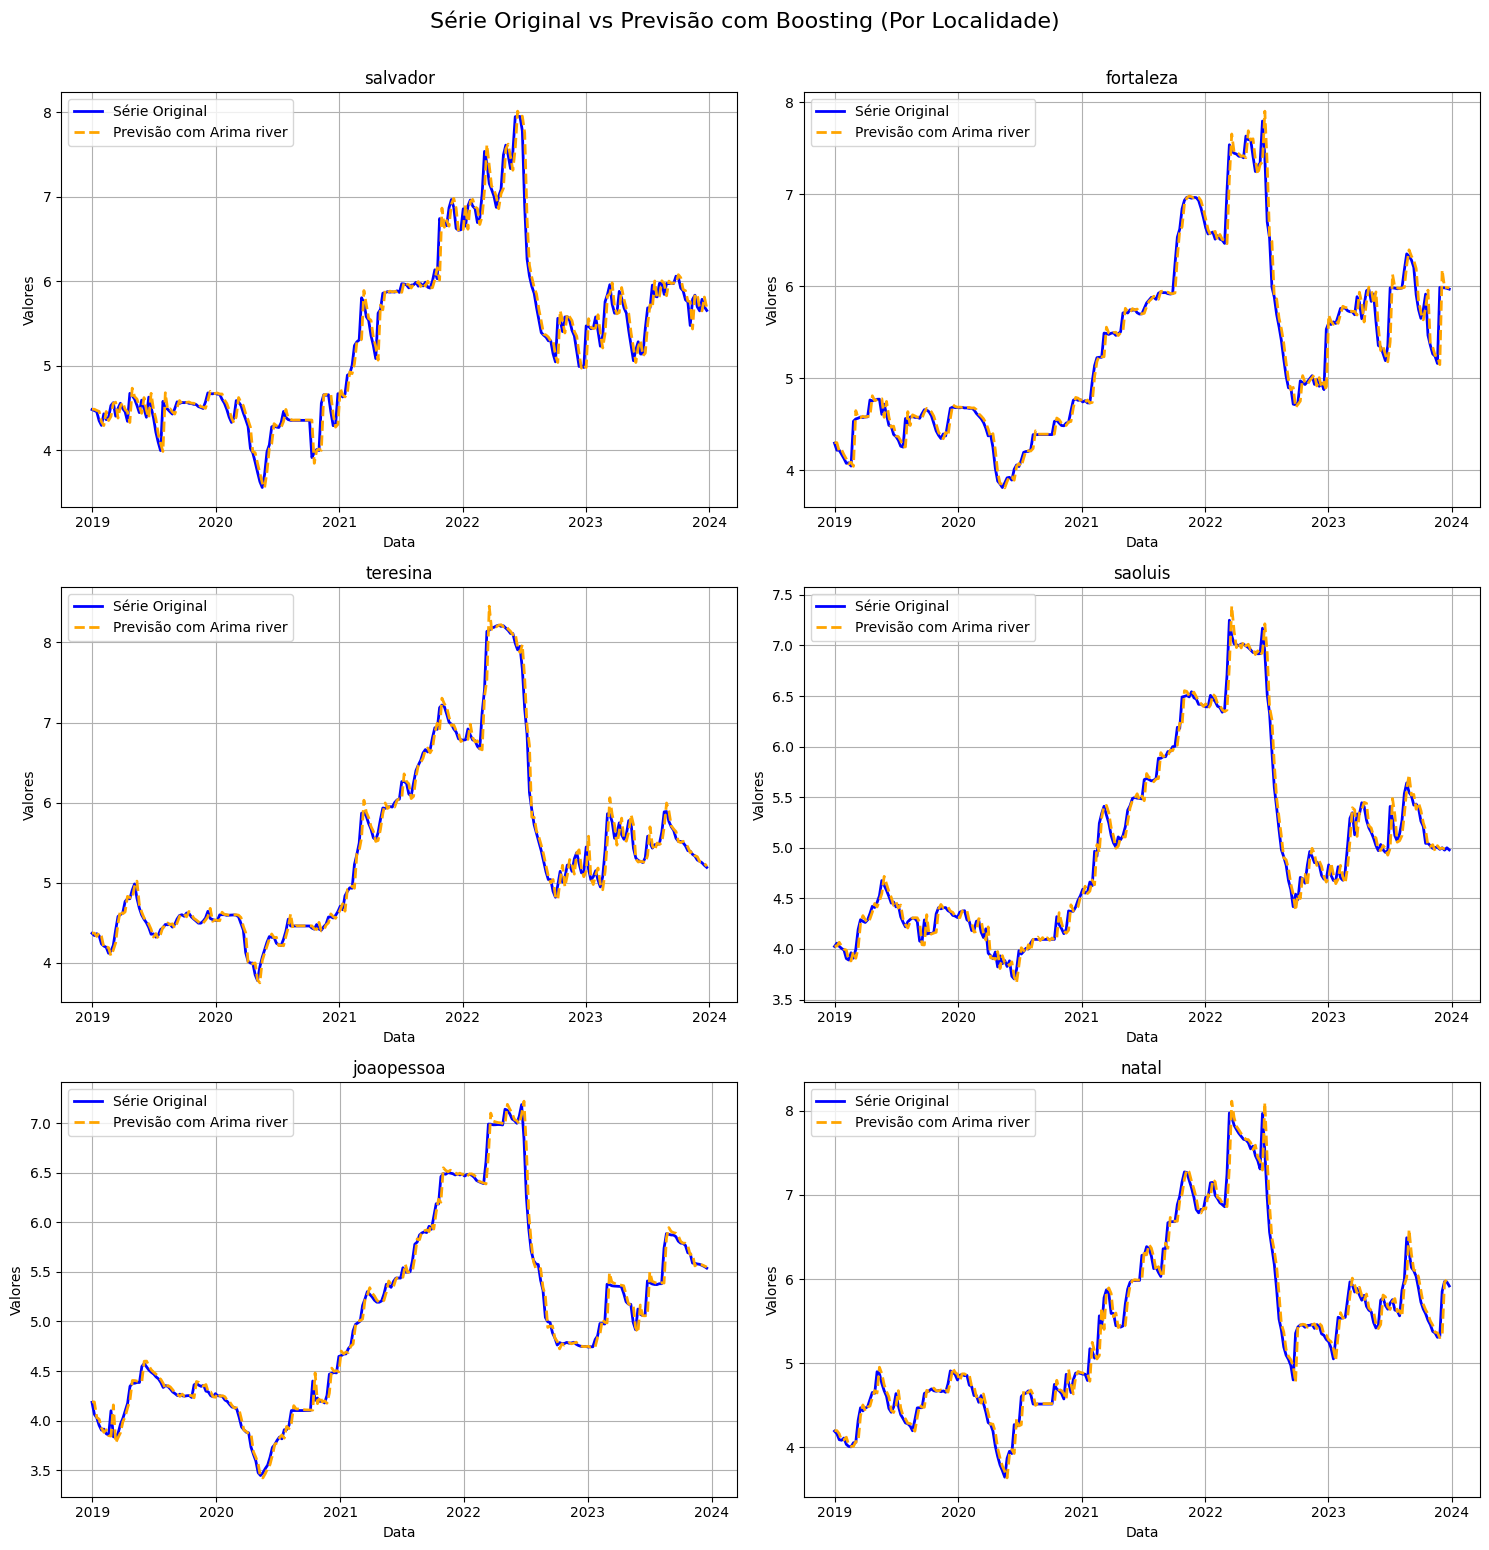

In [29]:
import matplotlib.pyplot as plt

# Configuração para a visualização em grade: 3 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3x2 layout
axes = axes.flatten()  # Achatar para facilitar a iteração

# Localidades e dados correspondentes
localidades = {
    'salvador': (y_salvador, y_forecast_salvador, y_predic_salvador_arima_river),
    'fortaleza': (y_fortaleza, y_forecast_fortaleza, y_predic_fortaleza_river),
    'teresina': (y_teresina, y_forecast_teresina, y_predic_teresina_river),
    'saoluis': (y_saoluis, y_forecast_saoluis, y_predic_saoluis_river),
    'joaopessoa': (y_joaopessoa, y_forecast_joaopessoa, y_predic_joaopessoa_river),
    'natal': (y_natal, y_forecast_natal, y_predic_natal_river)
}

# Dicionário para armazenar as previsões ajustadas (boosted) para cada localidade
y_boosted_forecast_river = {}

# Iterar sobre cada localidade para criar os gráficos
for ax, (localidade, (y_true, y_forecast, y_pred_series)) in zip(axes, localidades.items()):
    # Calcular a previsão ajustada com boosting
    y_boosted_forecast = y_forecast + y_pred_series

    # Armazenar as previsões ajustadas no dicionário
    y_boosted_forecast_river[localidade] = y_boosted_forecast

    # Plot da série original
    ax.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

    # Plot da previsão ajustada com boosting
    ax.plot(y_pred_series.index, y_boosted_forecast, label=f'Previsão com Arima river', color='orange', linestyle='--', linewidth=2)

    # Configurações do gráfico
    ax.set_title(localidade)
    ax.set_xlabel('Data')
    ax.set_ylabel('Valores')
    ax.legend()
    ax.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.suptitle('Série Original vs Previsão com Boosting (Por Localidade)', y=1.03, fontsize=16)
plt.show()




* Nesta etapa salvamos o boosting para cada uma das series.

In [30]:
y_boosted_forecast_fortaleza_river = y_boosted_forecast_river['fortaleza']
y_boosted_forecast_natal_river = y_boosted_forecast_river['natal']
y_boosted_forecast_joaopessoa_river = y_boosted_forecast_river['joaopessoa']
y_boosted_forecast_salvador_river = y_boosted_forecast_river['salvador']
y_boosted_forecast_saoluis_river = y_boosted_forecast_river['saoluis']
y_boosted_forecast_teresina_river= y_boosted_forecast_river['teresina']


* Análise das metricas de erro
A tabela apresenta o desempenho de vários modelos de previsão para diferentes localidades, incluindo "Random Walk", "NORMA-bayes", "NORMA-DICT", "ARIMA", e "ARIMA_river". As métricas de erro apresentadas são **Theil** e **R²**.

- **Theil**: A estatística de Theil é usada para medir o erro de previsão de um modelo. O valor de Theil próximo de 1 indica uma boa previsão, enquanto valores mais baixos indicam um erro maior. 
- **R²**: O **R²** (Coeficiente de Determinação) mede a proporção da variabilidade dos dados explicada pelo modelo. Valores próximos a 1 indicam que o modelo é capaz de explicar quase toda a variabilidade, enquanto valores baixos indicam um modelo com capacidade limitada de explicação.

* Análise dos Modelos

* **Random Walk**

    - O modelo **Random Walk** tem um desempenho sólido em todos os locais, com valores de **R²** geralmente entre 0.97 e 0.99 e **Theil** sempre igual a 1. Isso sugere que o **Random Walk** consegue gerar previsões bastante boas, embora com um erro constante de 1.

* **NORMA-bayes**

    - O modelo **NORMA-bayes** apresenta um desempenho muito bom, com **R²** variando entre 0.97 e 0.99, e valores de **Theil** que estão entre 0.92 e 1.06. Isso significa que ele é eficaz na explicação da variabilidade dos dados, com erros relativamente baixos, mas um pouco mais altos que o **Random Walk** em algumas localidades.

* **NORMA-DICT**

    - O modelo **NORMA-DICT** tem um desempenho muito semelhante ao **NORMA-bayes**, com valores de **R²** na faixa de 0.97 a 0.99 e **Theil** variando entre 0.92 e 1.06. A diferença de desempenho entre eles é quase imperceptível, ambos sendo altamente eficazes.

* **ARIMA**

    - O modelo **ARIMA** mostra uma boa capacidade preditiva, com **R²** geralmente em torno de 0.97 a 0.99 e **Theil** variando entre 0.81 e 1.05. Em comparação com os modelos anteriores, o **ARIMA** tem um desempenho um pouco superior em algumas localidades, especialmente com o **Theil** mais baixo em lugares como Teresina.

* **ARIMA_river**

    - O modelo **ARIMA_river** mostra resultados impressionantes. Ele tem **R²** variando de 0.97 a 0.99, com **Theil** entre 0.81 e 0.95. Este modelo é particularmente eficiente em locais como Teresina, São Luís e João Pessoa, apresentando valores de **Theil** abaixo de 1, o que significa que tem um erro de previsão muito menor.

* **Comparação de Desempenho**

    - **Melhor desempenho**: O **ARIMA_river** se destaca como o modelo com o melhor desempenho, pois apresenta valores de **Theil** consistentemente mais baixos (indicando menor erro) e **R²** muito alto. Ele se sai melhor que os outros modelos em várias localidades.
    - **Desempenho competitivo**: **NORMA-bayes** e **NORMA-DICT** têm desempenhos muito próximos e também são modelos eficazes, com erros um pouco maiores que o **ARIMA_river**.
    - **Random Walk**: Embora seja um modelo simples, o **Random Walk** apresenta resultados bastante bons, mas não supera os modelos mais sofisticados, como o **ARIMA_river**.

Portanto, **ARIMA_river** foi o modelo que obteve o melhor desempenho em termos de precisão nas previsões, seguido de perto pelos modelos **NORMA-bayes** e **NORMA-DICT**.


In [31]:
# Aplicando a função para diferentes localidades
computeAccuracyModels('ARIMA_river', 'Teresina', y_boosted_forecast_teresina_river, y_teresina)
computeAccuracyModels('ARIMA_river', 'Salvador', y_boosted_forecast_salvador_river, y_salvador)
computeAccuracyModels('ARIMA_river', 'São Luís', y_boosted_forecast_saoluis_river, y_saoluis)
computeAccuracyModels('ARIMA_river', 'João Pessoa', y_boosted_forecast_joaopessoa_river, y_joaopessoa)
computeAccuracyModels('ARIMA_river', 'Fortaleza', y_boosted_forecast_fortaleza_river, y_fortaleza)
computeAccuracyModels('ARIMA_river', 'Natal', y_boosted_forecast_natal_river, y_natal)

# Exibindo o DataFrame consolidado
display(df_metrics)

,Localidade,Theil,R2,Modelo
0,Teresina,1.000000,0.985459,Random Walk
1,Salvador,1.000000,0.968224,Random Walk
2,São Luís,1.000000,0.983725,Random Walk
3,João Pessoa,1.000000,0.989240,Random Walk
4,Fortaleza,1.000000,0.975590,Random Walk
5,Natal,1.000000,0.977150,Random Walk
6,Teresina,0.917474,0.986659,NORMA-bayes
7,Salvador,1.019486,0.967605,NORMA-bayes
8,São Luís,0.953636,0.984479,NORMA-bayes
9,João Pessoa,0.929416,0.989999,NORMA-bayes


# 4. Resultados

## 4.1 Theil

Interpretação dos resultados da metrica **theil** para os  modelos aplicados.

 O que é a métrica **Theil**?

A métrica **Theil** avalia a qualidade das previsões comparando-as com um modelo de referência (como o *Random Walk*). A interpretação da métrica é feita com base nos seguintes valores:

- **Theil = 1**: O modelo tem a mesma qualidade que o modelo de referência.
- **Theil < 1**: O modelo é melhor que o modelo de referência.
- **Theil > 1**: O modelo é pior que o modelo de referência.


* **Random Walk**:
   - O valor da métrica **Theil** está fixo em **1**, pois é o baseline usado para comparação.
   - Este valor mostra que as previsões do Random Walk são tomadas como referência.

* **NORMA-bayes e NORMA-DICT**:
   - Ambos os modelos apresentam valores de **Theil** levemente inferiores a 1.
   - As medianas estão entre 0,95 e 1, indicando que esses modelos oferecem uma melhoria marginal em relação ao Random Walk.
   - A amplitude dos boxplots indica uma variabilidade considerável no desempenho desses modelos.

* **ARIMA**:
   - O modelo ARIMA apresenta um valor mediano de **Theil** inferior aos modelos NORMA, sugerindo previsões mais precisas.
   - A variabilidade das previsões é menor do que a dos modelos NORMA.

* **ARIMA_river**:
   - Este modelo possui a menor mediana de **Theil** (próxima a 0,9) e a menor variabilidade entre todos os modelos.
   - Isso sugere que o **ARIMA_river** oferece o desempenho mais consistente e significativamente melhor em comparação ao Random Walk.

* Conclusão

Os resultados apresentados pelo boxplot indicam que:

- **Random Walk** é o baseline, mas não oferece uma qualidade superior para previsões.
   - **NORMA-bayes e NORMA-DICT** mostram uma leve melhora, mas ainda apresentam valores próximos ao baseline, indicando quepodem não ser as melhores opções em termos de ganho significativo de desempenho.
   - **ARIMA e ARIMA_river** demonstram desempenhos notavelmente melhores que o Random Walk:
   - **ARIMA_river** se destaca como o modelo mais eficiente, com menor erro e consistência maior, o que o torna a melhor escolha entre os modelos analisados.

Portanto, para aplicações onde a precisão das previsões é crítica, o **ARIMA_river** seria a escolha ideal, seguido pelo **ARIMA**. Os modelos NORMA podem ser considerados em situações onde as melhorias marginais são aceitáveis ou onde o uso de modelos estatísticos mais complexos não é viável.


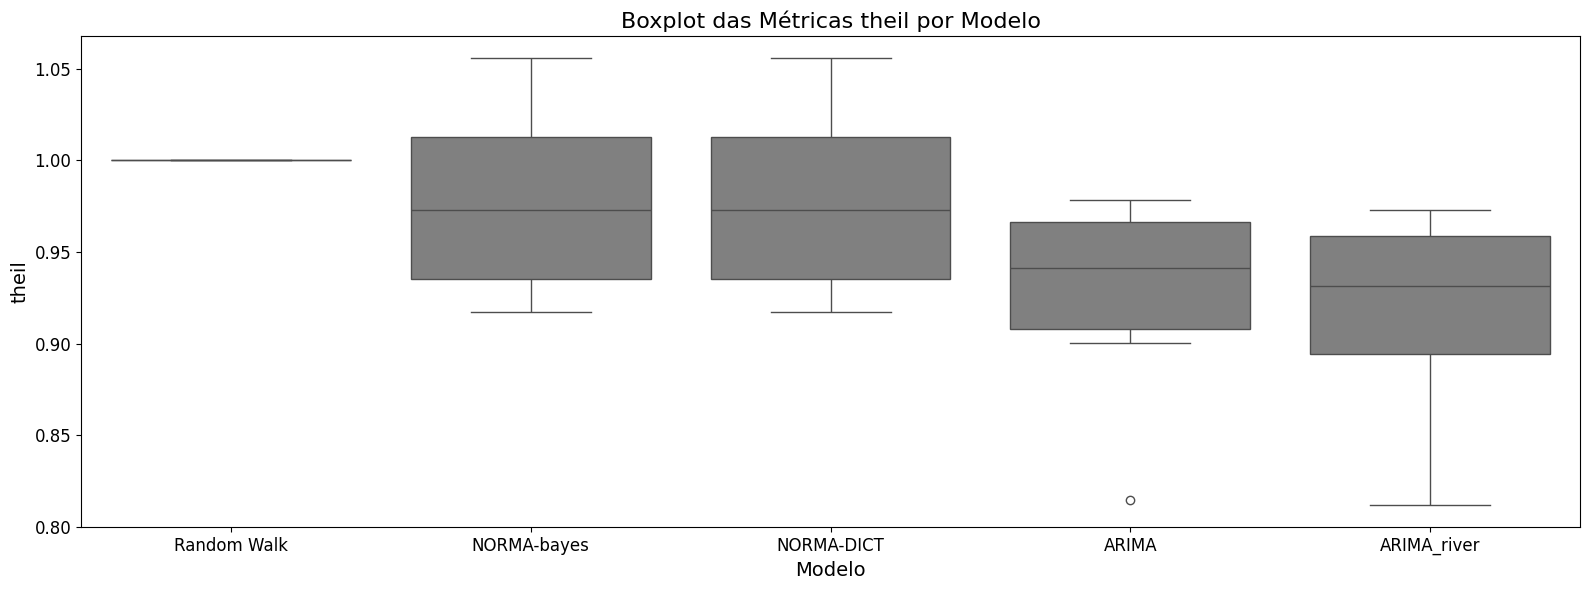

In [32]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_metrics, x="Modelo", y="Theil", color='grey')
# Ajustando os textos
plt.title('Boxplot das Métricas theil por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('theil', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()


## 4.2 R²

 Interpretação da Métrica **R²** para os modelos aplicados.

O que é a métrica R²?

O coeficiente de determinação (**R²**) mede a proporção da variância dos dados que é explicada pelo modelo. A interpretação dos valores de **R²** é feita da seguinte maneira:

   - **R² = 1**: Indica um ajuste perfeito, onde o modelo explica 100% da variância.
   - **R² próximo de 1**: Indica um modelo com bom desempenho.
   - **R² próximo de 0**: Indica que o modelo explica pouca ou nenhuma variância dos dados.
   - **R² < 0**: Indica que o modelo é pior que simplesmente usar a média dos dados como previsão.


* **Random Walk**:
   - O modelo apresenta valores de **R²** com mediana em aproximadamente **0,980**, indicando que consegue explicar bem a variância dos dados.
   - Existe uma variabilidade moderada nos valores de **R²**, com alguns casos abaixo de **0,975**, mostrando que o desempenho pode ser inconsistente.

* **NORMA-bayes e NORMA-DICT**:
   - Esses modelos possuem medianas levemente superiores ao **Random Walk**, próximas a **0,985**, sugerindo um ganho modesto de desempenho.
   - No entanto, possuem variabilidade maior, o que indica que, em alguns casos, o desempenho pode ser comparável ou até inferior ao Random Walk.

* **ARIMA**:
   - O modelo ARIMA apresenta valores de **R²** muito semelhantes aos dos modelos NORMA, com mediana ligeiramente acima de **0,985**.
   - A variabilidade dos valores é reduzida em comparação ao Random Walk, indicando um desempenho mais consistente.

* **ARIMA_river**:
   - Este modelo apresenta desempenho muito similar ao ARIMA, com mediana em **0,985** e variabilidade baixa.
   - Apesar disso, não se destaca significativamente dos demais modelos estatísticos.

* Conclusão

Os resultados indicam que todos os modelos possuem desempenhos bastante próximos, com valores altos de **R²** (próximos de 1), mostrando que todos explicam bem a variância dos dados. No entanto, há diferenças sutis:

   - **Random Walk** fornece uma base sólida, mas é superado em desempenho pelos outros modelos, principalmente em termos de mediana.
   - **NORMA-bayes e NORMA-DICT** oferecem um ganho modesto em relação ao Random Walk, mas apresentam maior variabilidade, o que pode tornar seus desempenhos menos confiáveis em cenários específicos.
   - **ARIMA e ARIMA_river** apresentam os melhores desempenhos gerais, com medianas elevadas e baixa variabilidade, indicando consistência superior.

**Recomendação**: Para previsões que exigem alto nível de precisão e consistência, os modelos **ARIMA** e **ARIMA_river** são as melhores opções. Os modelos NORMA podem ser explorados em cenários onde o uso de métodos estatísticos mais robustos seja inviável. Por outro lado, o Random Walk ainda é uma referência válida, especialmente em casos mais simples. 


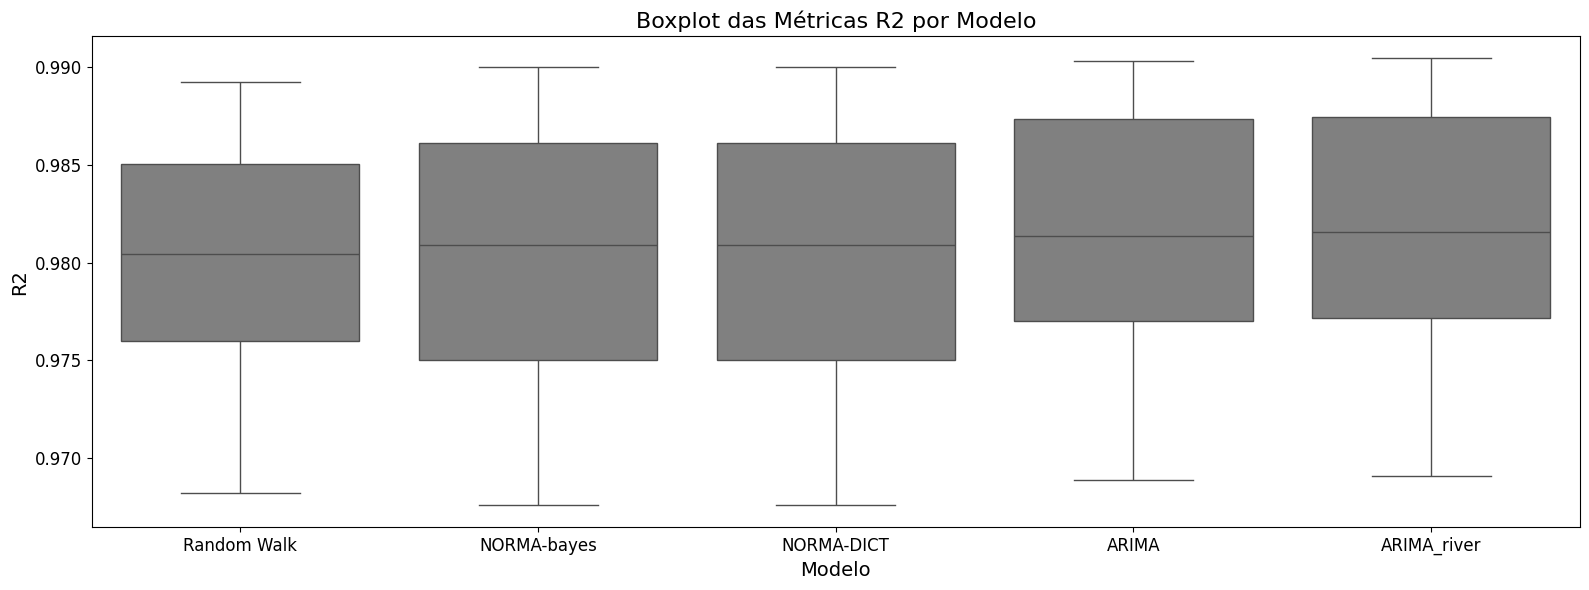

In [33]:
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_metrics, x="Modelo", y="R2", color='grey')

# Ajustando os textos
plt.title('Boxplot das Métricas R2 por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()
